## 1.导入数据填补方法

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from myPackage import module

In [2]:
def mean_imputer(data,missing_index):
    pm25_mean = data
    for i in missing_index:
        hour=data.loc[i,'hour']
        day=data.loc[i,'day']
        month=data.loc[i,'month']
        
        index = data[(data.hour==hour)&(data.day==day)&(data.month==month)].index.tolist()
        exist_index = [j for j in index if not(j==i)]
        pm25_mean.loc[i,'pm2.5']=np.mean(data.loc[exist_index,'pm2.5'])

    return pm25_mean

In [3]:
def knn_imputer(data):
    knn_imputer=KNNImputer(n_neighbors=40)
    pm25_knn = knn_imputer.fit_transform(data)
    
    return pm25_knn

In [4]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

# 平均填补

## 2.1 用平均填补法补全原数据

In [5]:
pm25_data = pd.read_csv('pm25_data.csv')
missing_index=np.where(np.isnan(pm25_data['pm2.5']))[0]
pm25_mean = mean_imputer(pm25_data,missing_index)

#检查是否还有数据缺失
pm25_mean[np.isnan(pm25_mean['pm2.5']).values==True]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,date
18946,18947,2012,2,29,10,NaN,-6,3.0,1022.0,1.79,0,0,0,0,1,0,2012-02-29
18947,18948,2012,2,29,11,NaN,-6,4.0,1022.0,1.79,0,0,1,0,0,0,2012-02-29
18948,18949,2012,2,29,12,NaN,-6,5.0,1021.0,1.79,0,0,0,0,1,0,2012-02-29
18949,18950,2012,2,29,13,NaN,-5,7.0,1020.0,3.58,0,0,0,0,1,0,2012-02-29
18950,18951,2012,2,29,14,NaN,-5,8.0,1019.0,5.37,0,0,0,0,1,0,2012-02-29
18951,18952,2012,2,29,15,NaN,-5,8.0,1019.0,7.16,0,0,0,0,1,0,2012-02-29


In [6]:
# 我们发现2012年2月29日也缺了数据，所以决定用2012年2月28日和3月1日的数据取平均作为2012年2月29日的数据
index1 = pm25_mean[(pm25_mean.day==28)&(pm25_mean.month==2)&(pm25_mean.year==2012)].index.tolist()
index2 = pm25_mean[(pm25_mean.day==29)&(pm25_mean.month==2)&(pm25_mean.year==2012)].index.tolist()
index3 = pm25_mean[(pm25_mean.day==1)&(pm25_mean.month==3)&(pm25_mean.year==2012)].index.tolist()
data1=pm25_mean.loc[index1,'pm2.5'].reset_index(drop=True)
data3=pm25_mean.loc[index3,'pm2.5'].reset_index(drop=True)
pm25_mean.loc[index2,'pm2.5']=[1/2*(data1[i]+data3[i]) for i in range(24)]
# 对数化
pm25_mean=module.log(pm25_mean)
# 得到week
week_list=[]
for date in pm25_mean['date']:
    week_list.append(pd.to_datetime(date).weekday())
pm25_mean['week']=week_list
# 存为csv文件
pm25_mean.to_csv("pm25_data_mean.csv",index=False)
# 得到 train data & test data
test_data,train_data=module.train_test_split(pm25_mean)

## 2.2 与task1类似，用xgboost预测模型拟合填补后的数据，并通过xgb.plot_importance进行特征选择

Mean squared error of test data for mean imputed data: 0.0076
R2 score: 0.6848


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

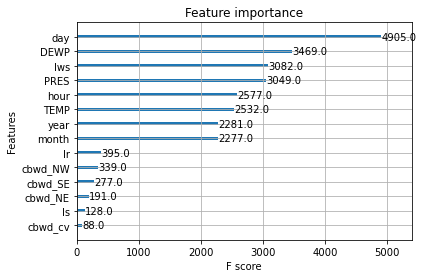

In [7]:
var=['year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_NE','cbwd_NW','cbwd_SE','cbwd_cv']
X_train = train_data[var]
X_test = test_data[var]
y_train = train_data['pm2.5_log']
y_test = test_data['pm2.5']

XGB_model=xgb.XGBRegressor(learning_rate=0.1,n_estimators=900,max_depth=5)
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
y_pred = np.round(np.exp(y_pred)) 

# 归一化
y_pred=preprocessing.minmax_scale(y_pred)
y_test=preprocessing.minmax_scale(y_test)
print("Mean squared error of test data for mean imputed data: %.4f" % mean_squared_error(y_pred, y_test))
print("R2 score: %.4f" % XGB_model.score(X_test,test_data['pm2.5_log']))

# 特征选择
xgb.plot_importance(XGB_model)

## 得到平均填补法补全的数据集的预测结果为R^2=0.6848，略低于原数据
## 筛选后day仍是最重要的特征；气象因素中仍是DEWP,lws,PRES,TEMP最重要，但各个因素的重要程度有所改变，重要性依次为DEWP,lws,PRES,TEMP

## 2.2 与task1类似，用相关系数矩阵进行特征筛选

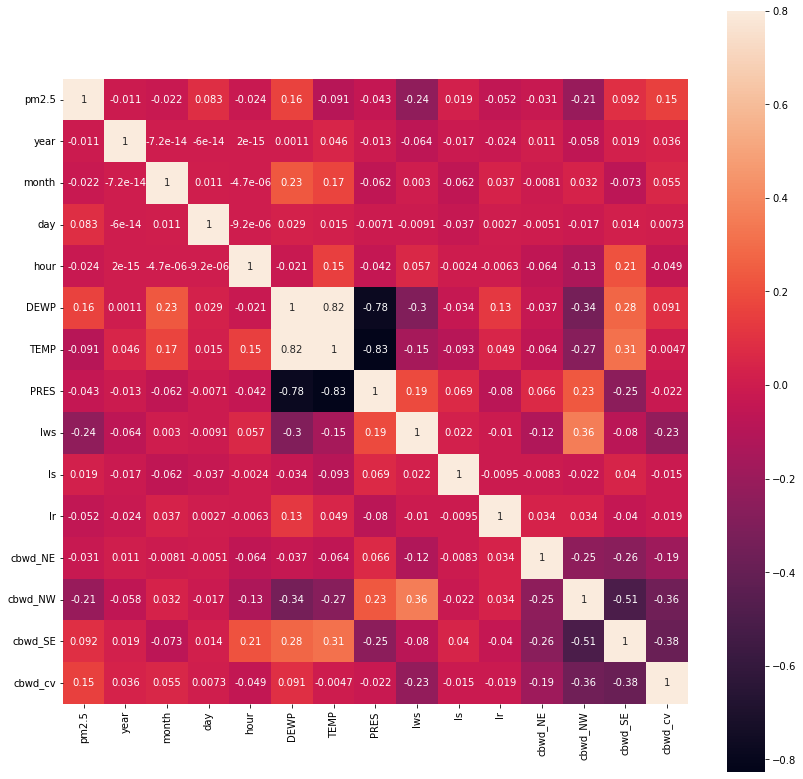

In [8]:
X=pm25_mean[['pm2.5','year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_NE','cbwd_NW','cbwd_SE','cbwd_cv']]
corrmatrix = X.corr()
plt.subplots(figsize=(14, 14))
sns.heatmap(corrmatrix, vmax=0.8, square=True, annot=True)
plt.show()

## 筛选后结果发生变化，与pm2.5相关性较高的因素：DEWP、lws、cbwd_NW、cbwd_cv

## 2.3 与task1类似， 通过PCA.explained_variance_ratio_选择特征并尝试降维

array([0.81476227, 0.93698415, 0.96192403, 0.97877016, 0.98886732,
       0.99506625, 0.99835893, 0.99899759, 0.99962027, 0.99980266,
       0.99988853, 0.99995792, 1.        , 1.        ])

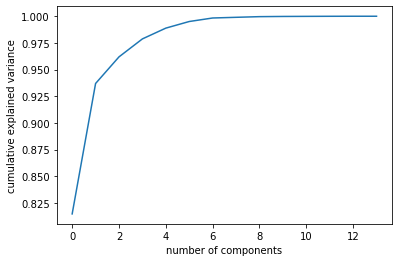

In [9]:
from sklearn.decomposition import PCA
pca=PCA().fit(X.drop('pm2.5',axis=1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.cumsum(pca.explained_variance_ratio_)

## PCA给出的结果与原数据类似，取前3个主成分作为特征，其中第一主成分主要反映了对pm2.5的影响

## 2.4 用由平均填补法得到的新数据进行task2的运行

## 2.4.1 与task2类似，用折线图记录每年一天24小时pm2.5的变化趋势，取每年每小时的平均浓度作为当年该小时的对应值

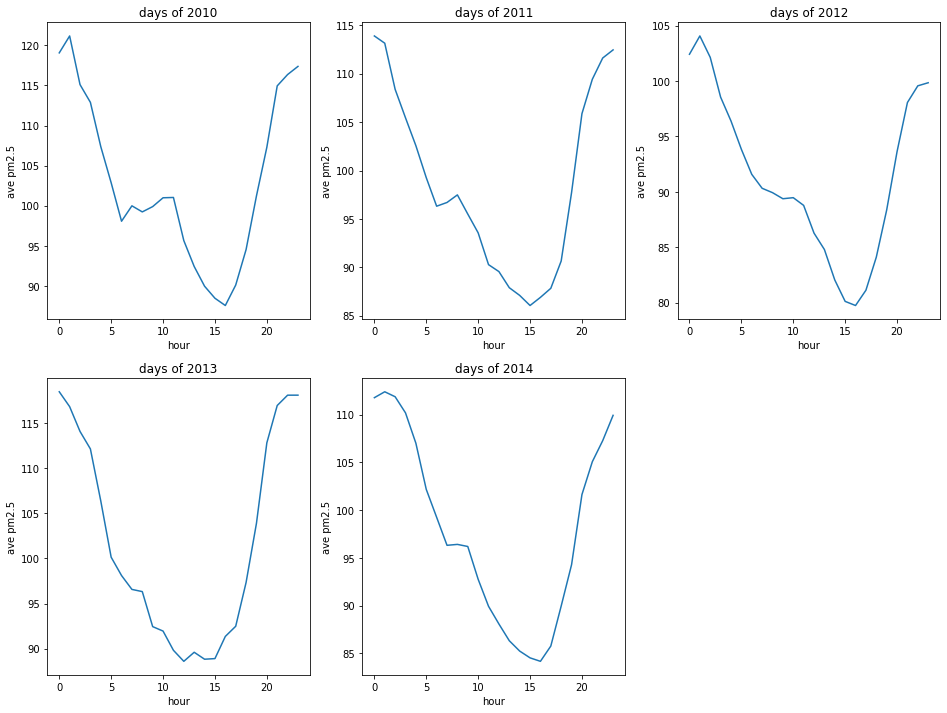

In [10]:
## PM2.5在一天内的波动值
Year=[2010,2011,2012,2013,2014]
Hour=range(24)
day_of_year1=[[],[],[],[],[]]

variation_of_day1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    for hour in Hour:
        pm25_hour_year=pm25_year[pm25_year.hour==hour]
        mean=np.mean(pm25_hour_year['pm2.5'])
        day_of_year1[index].append(mean)
        
variation_of_day1=variation_of_day1.append(day_of_year1)
variation_of_day1.index=Year    

plt.figure(figsize=(16,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day1.iloc[i,:])
    plt.title('days of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5')

In [11]:
variation_of_day1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2010,119.057534,121.166667,115.103881,112.889269,107.371918,102.870548,98.073516,99.992009,99.234703,99.895434,...,89.971918,88.472374,87.566438,90.113927,94.538584,101.227626,107.293151,114.944521,116.356621,117.372374
2011,113.904338,113.155708,108.394521,105.447032,102.568493,99.265297,96.318037,96.704338,97.486530,95.507991,...,87.105251,86.060046,86.902511,87.838813,90.657078,97.729680,105.876712,109.431050,111.625799,112.464840
2012,102.412568,104.062842,102.133197,98.546448,96.394353,93.840164,91.583106,90.323770,89.930328,89.381831,...,82.055328,80.123059,79.751138,81.128188,84.109517,88.363616,93.627732,98.059199,99.564891,99.842668
2013,118.432420,116.785616,114.042466,112.106849,106.350685,100.124658,98.096575,96.560959,96.317808,92.442466,...,88.835160,88.903196,91.357534,92.480594,97.326712,103.880137,112.780822,116.912329,118.055479,118.056849
2014,111.790411,112.409589,111.888813,110.197032,107.015525,102.178539,99.254566,96.317123,96.413242,96.194292,...,85.233562,84.521233,84.158447,85.758219,89.954338,94.284475,101.636301,105.077626,107.284932,109.938813


## 折线图结果与原数据task2的基本一样，5年间pm2.5每天的变化趋势均相似，0点至15点浓度下降，15点至24点浓度上升

## 2.4.2 与task2类似，用折线图记录每年一周每天pm2.5的变化趋势，取每年每星期一天的平均浓度作为当年该天的对应值

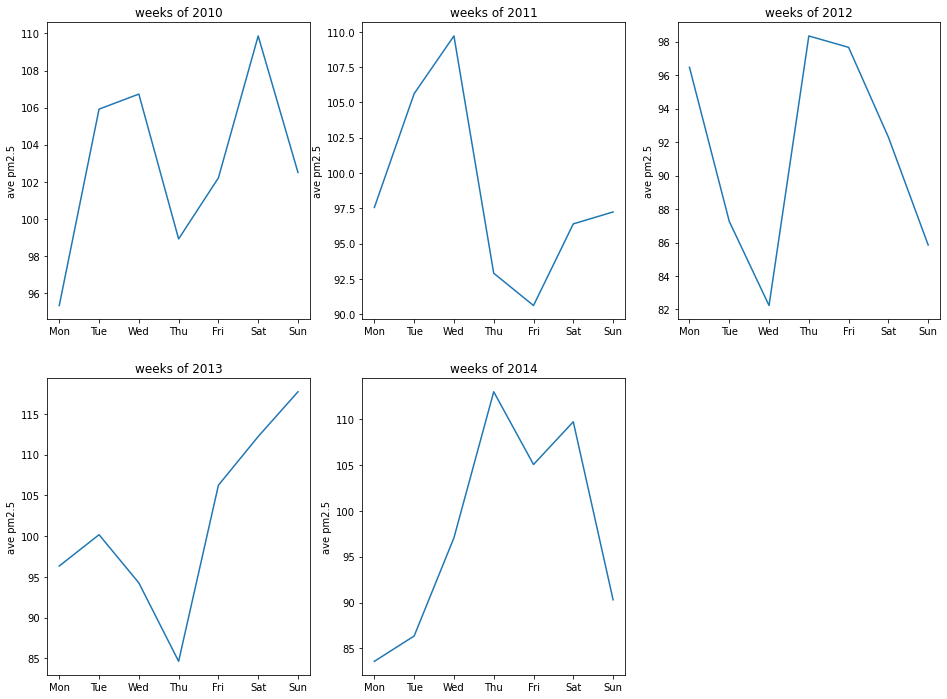

In [12]:
# PM2.5在一周的波动值
Week=range(7)
week_of_year1=[[],[],[],[],[]]

variation_of_week1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    for week in Week:
        pm25_week_year=pm25_year[pm25_year.week==week]
        mean=np.mean(pm25_week_year['pm2.5'])
        week_of_year1[index].append(mean)        
variation_of_week1=variation_of_week1.append(week_of_year1)
variation_of_week1.index=Year  

plt.figure(figsize=(16,12))
Week_str=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Week_str,variation_of_week1.iloc[i,:])
    plt.title('weeks of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [13]:
variation_of_week1

,0,1,2,3,4,5,6
2010,95.338742,105.918536,106.729033,98.925414,102.214164,109.861111,102.506343
2011,97.559495,105.625000,109.712607,92.901309,90.614650,96.398257,97.242521
2012,96.468553,87.264824,82.237847,98.340278,97.659109,92.293470,85.851350
2013,96.339076,100.180490,94.268029,84.635083,106.253072,112.237580,117.731771
2014,83.591947,86.352230,97.055031,112.972289,105.044471,109.700321,90.300881


## 与task2原数据结果相比，除少数数值外，填充的数据结果基本不变，每年每星期pm2.5平均浓度变化趋势完全不同

## 2.4.3 与task2类似，用折线图记录每年每月pm2.5的变化趋势，取每年每月的平均浓度作为当年该月的对应值

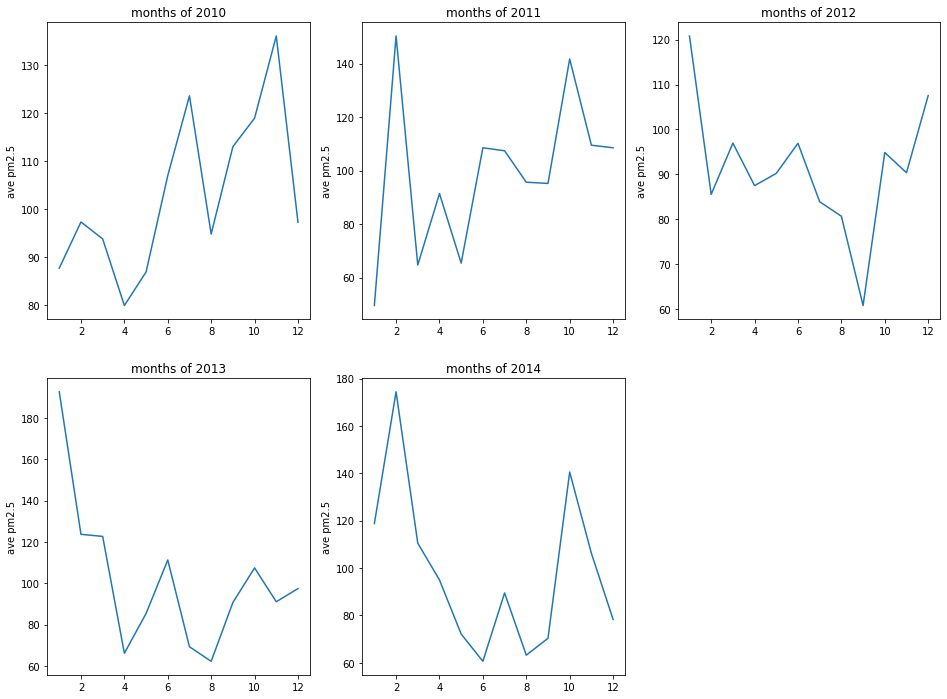

In [14]:
## PM2.5在一年内数月的波动值
Month=range(1,13)
month_of_year1=[[],[],[],[],[]]

variation_of_month1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    for month in Month:
        pm25_month_year=pm25_year[pm25_year.month==month]
        mean=np.mean(pm25_month_year['pm2.5'])
        month_of_year1[index].append(mean)        
variation_of_month1=variation_of_month1.append(month_of_year1)
variation_of_month1.index=Year 

plt.figure(figsize=(16,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month1.iloc[i,:])
    plt.title('months of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [15]:
variation_of_month1

,0,1,2,3,4,5,6,7,8,9,10,11
2010,87.761761,97.388393,93.854839,79.989583,86.964830,107.040278,123.647849,94.872200,113.060532,119.005712,136.120833,97.333333
2011,49.615255,150.321429,64.755712,91.427083,65.452285,108.553356,107.421819,95.677419,95.231944,141.711694,109.501736,108.552083
2012,120.815076,85.515805,96.941196,87.472222,90.203629,96.900694,83.878136,80.656250,60.760446,94.843414,90.346181,107.530130
2013,192.628584,123.714658,122.705645,66.231250,85.434588,111.308681,69.354839,62.318660,90.753935,107.476142,91.113542,97.484543
2014,118.788306,174.454613,110.514785,95.004514,72.143817,60.632060,89.510081,63.229167,70.360764,140.540323,106.270486,78.343974


## 结果与原数据的类似，每年每月pm2.5平均浓度变化趋势不同，但从2011年后，基本从2月到10月浓度维持在相对较低水平，而其余月份基本维持在相对较高水平

## 2.4.4 与task2类似，用折线图记录每年四季pm2.5的变化趋势，取每年每个季度的平均浓度作为当年该季度的对应值

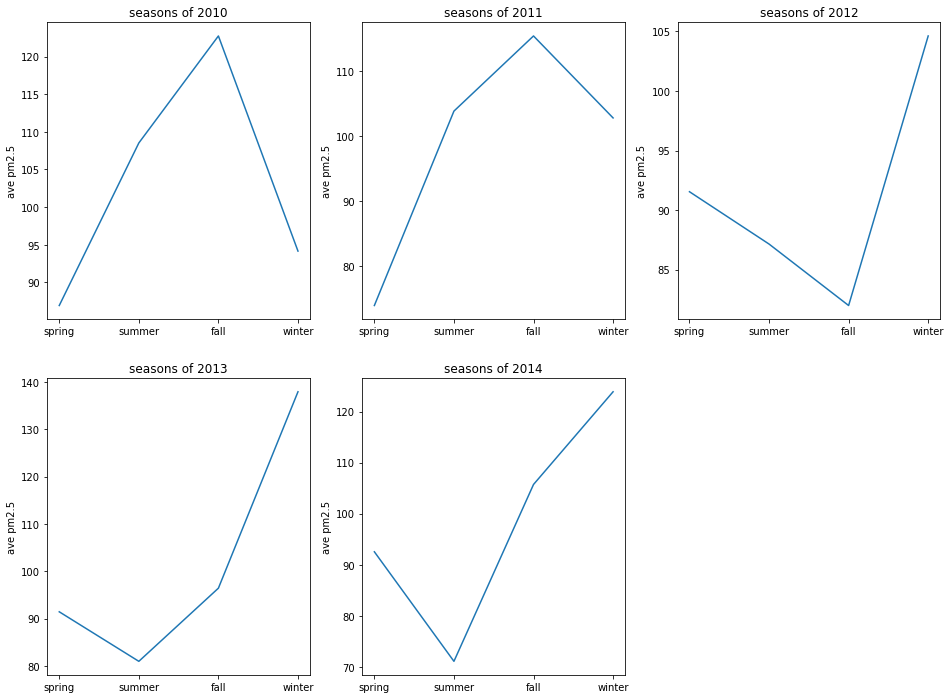

In [16]:
## PM2.5在四季的波动值
season_of_year1=[[],[],[],[],[]]

variation_of_season1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    mean_spring=(variation_of_month1.loc[year,2]+variation_of_month1.loc[year,3]+variation_of_month1.loc[year,4])/3
    mean_summer=(variation_of_month1.loc[year,5]+variation_of_month1.loc[year,6]+variation_of_month1.loc[year,7])/3
    mean_fall=(variation_of_month1.loc[year,8]+variation_of_month1.loc[year,9]+variation_of_month1.loc[year,10])/3
    mean_winter=(variation_of_month1.loc[year,11]+variation_of_month1.loc[year,0]+variation_of_month1.loc[year,1])/3
    season_of_year1[index].append(mean_spring)
    season_of_year1[index].append(mean_summer)
    season_of_year1[index].append(mean_fall)
    season_of_year1[index].append(mean_winter)   
variation_of_season1=variation_of_season1.append(season_of_year1)
variation_of_season1.index=Year   

plt.figure(figsize=(16,12))
Seasons=['spring','summer','fall','winter']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season1.iloc[i,:])
    plt.title('seasons of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [17]:
variation_of_season1

,0,1,2,3
2010,86.936417,108.520109,122.729026,94.161162
2011,73.878360,103.884198,115.481791,102.829589
2012,91.539016,87.145027,81.983347,104.620337
2013,91.457161,80.994060,96.447873,137.942595
2014,92.554372,71.123769,105.723858,123.862298


## 结果与原数据类似，除少量数值变化外，浓度变化趋势基本相同，2010年和2011年，秋季达到平均浓度最高值，浓度从春夏秋上升，秋冬下降。2012、2013、2014年夏季平均浓度最低，夏秋冬三季依次上升，浓度在冬季最高，之后下降

## 2.4.5 与task2类似，用折线图记录每年pm2.5的变化趋势，取每年平均浓度作为当年的对应值

Text(0, 0.5, 'ave pm2.5')

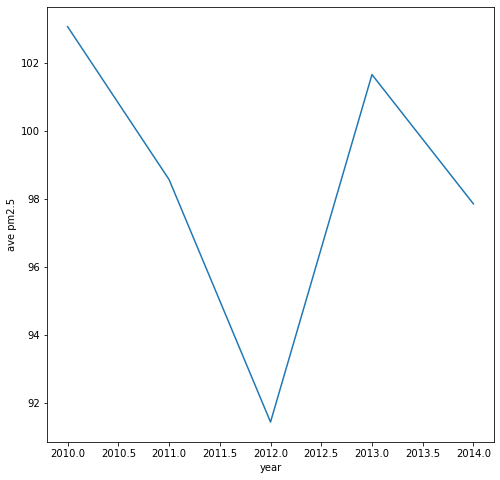

In [18]:
## PM2.5在5年内的波动值
varaition_of_year1=[]
for year in Year:
    pm25_year=pm25_mean[pm25_mean.year==year]
    mean=np.mean(pm25_year['pm2.5'])
    varaition_of_year1.append(mean) 

plt.figure(figsize=(8,8))
plt.plot(Year,varaition_of_year1)
plt.xlabel('year')
plt.ylabel('ave pm2.5')

In [19]:
varaition_of_year1

[103.06813165905635,
 98.57314497716895,
 91.4420879829955,
 101.65952245053273,
 97.85739155251144]

## 与原数据结果类似，除平均浓度数值范围有细微变化外，基本趋势不变。这五年间2012年平均浓度最低， 2010至2012年连续下降，2013年达到较高水平后2014年再次下降至2011年水平

## 2.4.6 与task2类似，对于填补后的数据，利用上述与时间有关的pm2.5平均浓度信息，分别使用每条数据的时间信息和天气信息，运用task1中提出的xgboost模型、训练集和测试集，实现对pm2.5浓度的预测，同时使用score作为预测结果好坏的测量标准，认为越接近1预测效果越好

In [20]:
from xgboost import XGBRegressor

## 2.4.6.1 与task2类似，分别使用每年一天24小时数据的时间信息和天气信息，对每小时pm2.5平均浓度进行预测，将两种方法下每年每小时的预测score用折线图分别绘出

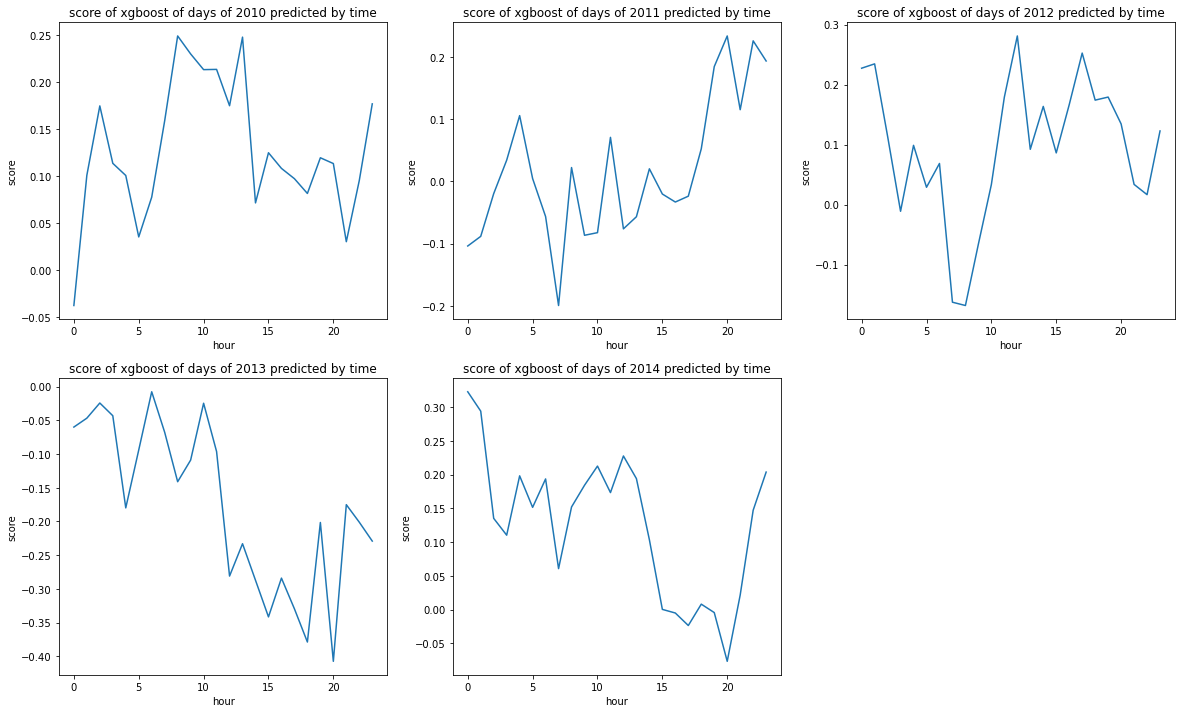

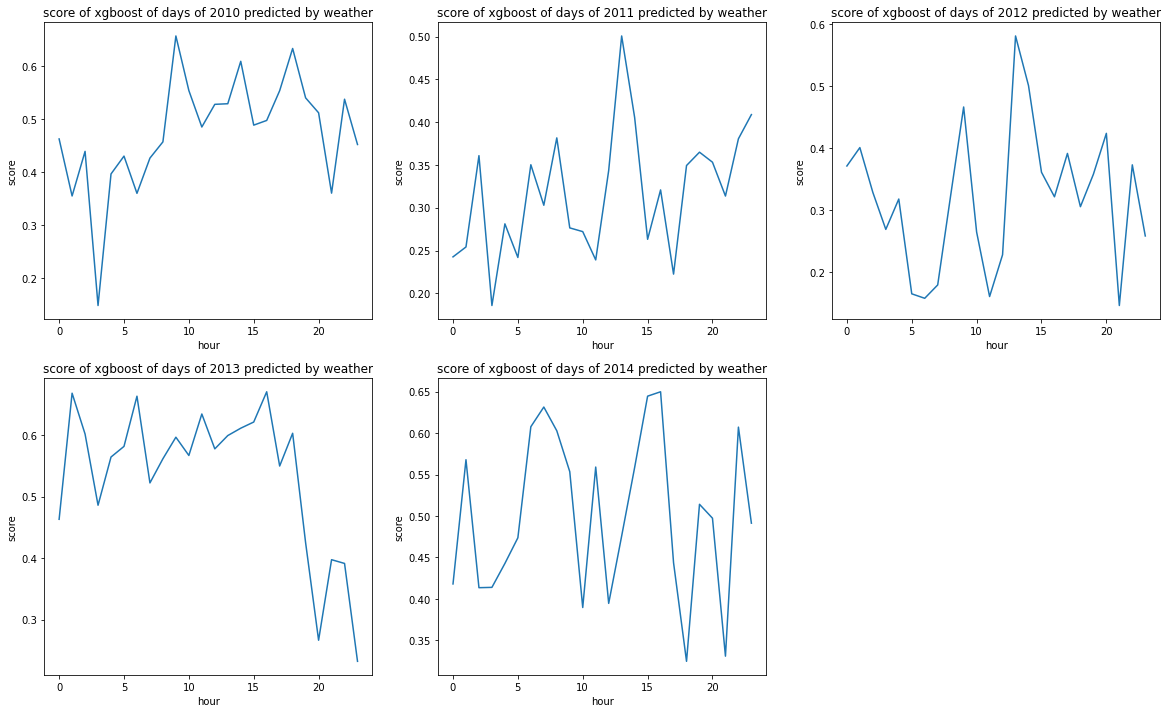

In [21]:
## 基于PM2.5在一天内的波动值，用xgboost进行预测
Year=[2010,2011,2012,2013,2014]
Hour=range(24)
day_of_year_train1=[[],[],[],[],[]]
day_of_year_test1=[[],[],[],[],[]]
score_of_year_time1 = [[],[],[],[],[]]
score_of_year_weather1 = [[],[],[],[],[]]
var_time = ['year', 'month', 'day', 'hour', 'week']
var_weather = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

variation_of_day_time1=pd.DataFrame()
variation_of_day_weather1=pd.DataFrame()
for index, year in enumerate(Year):
    train_data_year=train_data[train_data.year==year]
    test_data_year=test_data[test_data.year==year]
    for hour in Hour:
        train_data_hour_year=train_data_year[train_data_year.hour==hour]
        test_data_hour_year=test_data_year[test_data_year.hour==hour]
        
        ## Only use time to predict
        X_train_data_hour_year_time = train_data_hour_year[var_time]
        X_test_data_hour_year_time = test_data_hour_year[var_time]
        y_train_data_hour_year = train_data_hour_year['pm2.5_log']
        y_test_data_hour_year = test_data_hour_year['pm2.5']
        XGB_model_time=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_time.fit(X_train_data_hour_year_time, y_train_data_hour_year)

        y_pred_hour_year_time = XGB_model_time.predict(X_test_data_hour_year_time)
        y_pred_hour_year_time = np.round(np.exp(y_pred_hour_year_time)) 
        y_pred_hour_year_time = preprocessing.minmax_scale(y_pred_hour_year_time)
        y_test_data_hour_year = preprocessing.minmax_scale(y_test_data_hour_year)
        score_of_year_time1[index].append(XGB_model_time.score(X_test_data_hour_year_time,test_data_hour_year['pm2.5_log']))   

        ## Only use weather to predict
        X_train_data_hour_year_weather = train_data_hour_year[var_weather]
        X_test_data_hour_year_weather = test_data_hour_year[var_weather]
        XGB_model_weather = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_weather.fit(X_train_data_hour_year_weather, y_train_data_hour_year)

        y_pred_hour_year_weather = XGB_model_weather.predict(X_test_data_hour_year_weather)
        y_pred_hour_year_weather = np.round(np.exp(y_pred_hour_year_weather)) 
        y_pred_hour_year_weather = preprocessing.minmax_scale(y_pred_hour_year_weather)
        y_test_data_hour_year = preprocessing.minmax_scale(y_test_data_hour_year)
        score_of_year_weather1[index].append(XGB_model_weather.score(X_test_data_hour_year_weather,test_data_hour_year['pm2.5_log']))

variation_of_day_time1=variation_of_day_time1.append(score_of_year_time1)
variation_of_day_weather1=variation_of_day_weather1.append(score_of_year_weather1)
plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day_time1.iloc[i,:])
    plt.title('score of xgboost of days of %d predicted by time' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day_weather1.iloc[i,:])
    plt.title('score of xgboost of days of %d predicted by weather' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('score')

In [22]:
variation_of_day_time1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.037483,0.101016,0.174856,0.113766,0.100841,0.035487,0.077764,0.159086,0.249265,0.230154,...,0.071675,0.125024,0.108383,0.097434,0.081709,0.119689,0.113530,0.030400,0.095519,0.177032
1,-0.103656,-0.088180,-0.019566,0.034137,0.105731,0.004649,-0.056374,-0.199237,0.022333,-0.086457,...,0.020299,-0.020188,-0.033046,-0.023655,0.052450,0.184439,0.233666,0.115257,0.225816,0.193450
2,0.227275,0.234499,0.114063,-0.011080,0.098768,0.028920,0.068575,-0.162571,-0.168071,-0.065697,...,0.163616,0.086183,0.166446,0.252472,0.174080,0.179175,0.134480,0.033703,0.016605,0.122738
3,-0.059887,-0.046679,-0.024203,-0.043065,-0.179843,-0.093903,-0.007505,-0.067677,-0.141005,-0.108929,...,-0.287272,-0.341617,-0.284081,-0.329644,-0.378926,-0.201496,-0.407559,-0.175070,-0.201098,-0.229111
4,0.322958,0.294229,0.135228,0.110296,0.198284,0.151557,0.193695,0.060686,0.152116,0.184293,...,0.103525,0.000232,-0.005142,-0.023669,0.008000,-0.004481,-0.076780,0.021597,0.147308,0.203850


In [23]:
variation_of_day_weather1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.463175,0.355465,0.439692,0.148601,0.397043,0.430741,0.360435,0.427003,0.457629,0.657642,...,0.609773,0.489238,0.498087,0.554335,0.634018,0.540722,0.512537,0.360805,0.538183,0.452658
1,0.242600,0.254181,0.360900,0.185756,0.281189,0.241897,0.350279,0.302937,0.381670,0.276478,...,0.405547,0.263135,0.320861,0.222468,0.349365,0.364949,0.353239,0.313696,0.380630,0.408885
2,0.371615,0.401322,0.329053,0.269312,0.318278,0.165299,0.158079,0.179637,0.324204,0.466853,...,0.501327,0.361530,0.321893,0.391892,0.305935,0.358253,0.424301,0.146429,0.373471,0.258684
3,0.463262,0.668284,0.601897,0.486143,0.564541,0.581808,0.663416,0.522434,0.561725,0.596729,...,0.611388,0.621423,0.670615,0.549894,0.603153,0.425058,0.266684,0.397616,0.391516,0.232380
4,0.417926,0.567925,0.413405,0.413795,0.442679,0.473672,0.607768,0.631547,0.602882,0.553481,...,0.558511,0.644679,0.649985,0.443518,0.324492,0.514093,0.497325,0.330721,0.607278,0.491302


## 相比于原数据，两种方法给出的预测分数变化趋势均与原来的相似，运用天气信息的预测准度明显更高。但这个精度相对于原数据明显下降，最高低于使用原先所有训练集得到的预测模型的准度

## 2.4.6.2 与task2相似，分别使用填补后每年每月数据的时间信息和天气信息，对每月pm2.5平均浓度进行预测，将两种方法下每年每月的预测score用折线图分别绘出

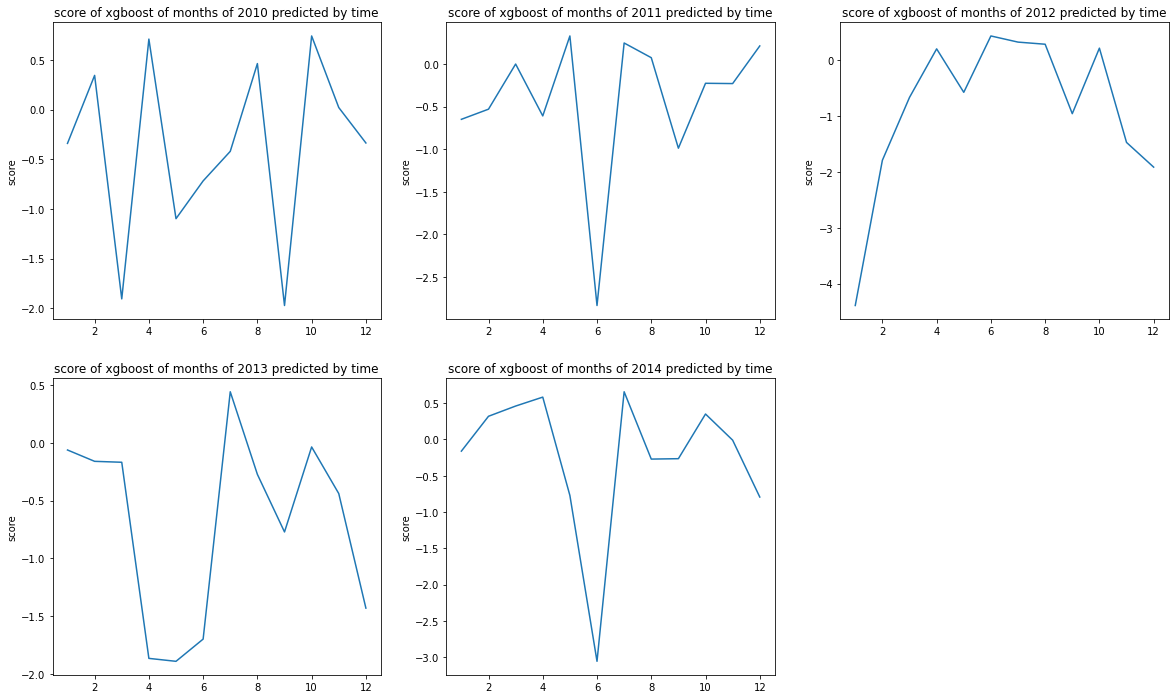

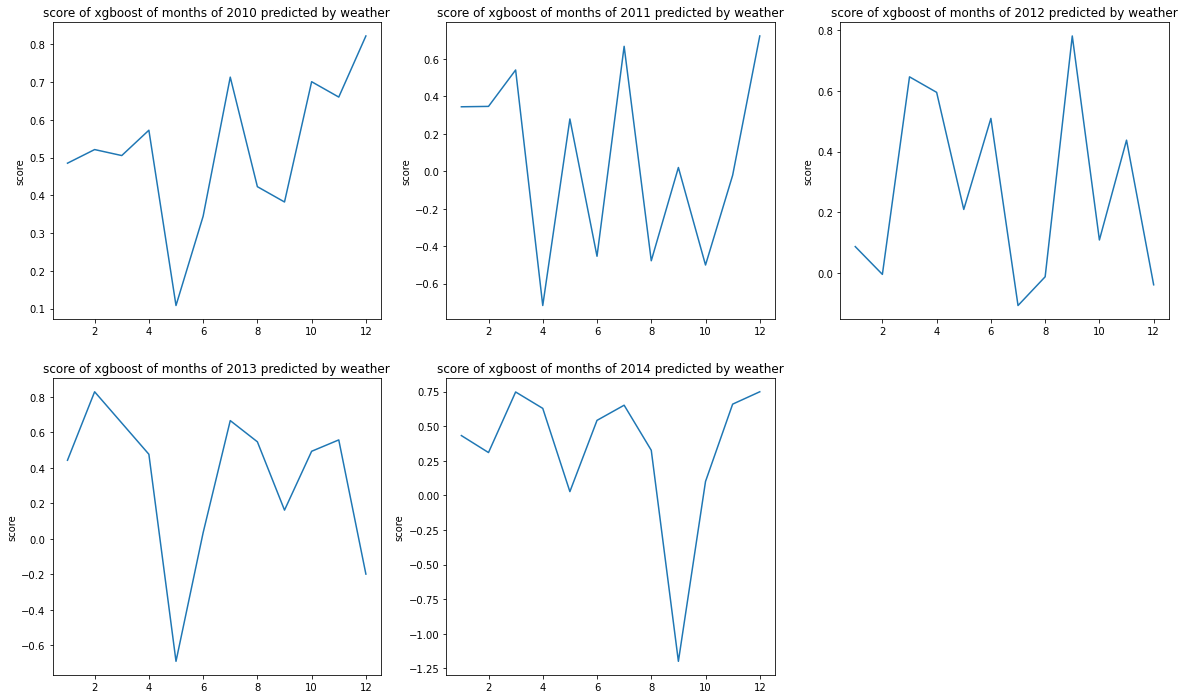

In [24]:
## 基于PM2.5在一年内数月的波动值， 用xgboost进行预测
Month = range(1,13)
week_of_year1=[[],[],[],[],[]]
score_of_month_weather1 = [[],[],[],[],[]]
score_of_month_time1 = [[],[],[],[],[]]

variation_of_month_time1=pd.DataFrame()
variation_of_month_weather1=pd.DataFrame()
for index, year in enumerate(Year):
    train_data_year=train_data[train_data.year==year]
    test_data_year=test_data[test_data.year==year]
    for month in Month:
        train_data_month_year=train_data_year[train_data_year.month==month]
        test_data_month_year=test_data_year[test_data_year.month==month]
        
        ## Only use time to predict
        X_train_data_month_year_time = train_data_month_year[var_time]
        X_test_data_month_year_time = test_data_month_year[var_time]
        y_train_data_month_year = train_data_month_year['pm2.5_log']
        y_test_data_month_year = test_data_month_year['pm2.5']
        XGB_model_time=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_time.fit(X_train_data_month_year_time, y_train_data_month_year)

        y_pred_month_year_time = XGB_model_time.predict(X_test_data_month_year_time)
        y_pred_month_year_time = np.round(np.exp(y_pred_month_year_time)) 
        y_pred_month_year_time = preprocessing.minmax_scale(y_pred_month_year_time)
        y_test_data_month_year = preprocessing.minmax_scale(y_test_data_month_year)
        score_of_month_time1[index].append(XGB_model_time.score(X_test_data_month_year_time,test_data_month_year['pm2.5_log']))   

        ## Only use weather to predict
        X_train_data_month_year_weather = train_data_month_year[var_weather]
        X_test_data_month_year_weather = test_data_month_year[var_weather]
        XGB_model_weather = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_weather.fit(X_train_data_month_year_weather, y_train_data_month_year)

        y_pred_month_year_weather = XGB_model_weather.predict(X_test_data_month_year_weather)
        y_pred_month_year_weather = np.round(np.exp(y_pred_month_year_weather)) 
        y_pred_month_year_weather = preprocessing.minmax_scale(y_pred_month_year_weather)
        y_test_data_month_year = preprocessing.minmax_scale(y_test_data_month_year)
        score_of_month_weather1[index].append(XGB_model_weather.score(X_test_data_month_year_weather,test_data_month_year['pm2.5_log'])) 

variation_of_month_time1=variation_of_month_time1.append(score_of_month_time1)
variation_of_month_weather1=variation_of_month_weather1.append(score_of_month_weather1)
plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month_time1.iloc[i,:])
    plt.title('score of xgboost of months of %d predicted by time' % Year[i])
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month_weather1.iloc[i,:])
    plt.title('score of xgboost of months of %d predicted by weather' % Year[i])
    plt.ylabel('score')

In [25]:
variation_of_month_time1

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.338548,0.346103,-1.904089,0.711337,-1.096566,-0.716418,-0.418752,0.464820,-1.970793,0.742950,0.022309,-0.334421
1,-0.649614,-0.530581,-0.001401,-0.609666,0.327828,-2.832711,0.245290,0.072992,-0.988170,-0.227102,-0.230520,0.210873
2,-4.389388,-1.788590,-0.663142,0.205786,-0.572387,0.436812,0.326685,0.288677,-0.954663,0.218447,-1.469489,-1.911884
3,-0.060734,-0.158978,-0.167026,-1.865168,-1.890642,-1.698227,0.443398,-0.271695,-0.770374,-0.034501,-0.438089,-1.429977
4,-0.160527,0.319677,0.460526,0.583537,-0.770967,-3.055540,0.657222,-0.270041,-0.264434,0.350737,-0.009396,-0.792763


In [26]:
variation_of_month_weather1

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.485421,0.521514,0.505635,0.572718,0.108402,0.344922,0.713370,0.423196,0.382643,0.701248,0.660548,0.822447
1,0.344355,0.346419,0.540712,-0.716010,0.279292,-0.453219,0.666909,-0.477302,0.020360,-0.499932,-0.021116,0.722236
2,0.086520,-0.005110,0.646563,0.595400,0.209148,0.509423,-0.107813,-0.013043,0.781449,0.108413,0.437697,-0.039437
3,0.443168,0.828980,0.652994,0.476914,-0.689660,0.034904,0.666554,0.547094,0.162159,0.493749,0.557729,-0.198265
4,0.432083,0.309519,0.746950,0.628568,0.027360,0.541969,0.651416,0.325977,-1.198308,0.100762,0.659154,0.748499


## 相比于原数据，两种方法给出的预测分数变化趋势和数值均与原来的相似，用每月平均浓度预测时只用天气信息可以达到更高精度，但预测准度同样更加不稳定

## 2.4.6.3 与task2类似，分别使用填补后每年每季数据的时间信息和天气信息，对每季pm2.5平均浓度进行预测，将两种方法下每年每季的预测score用折线图分别绘出

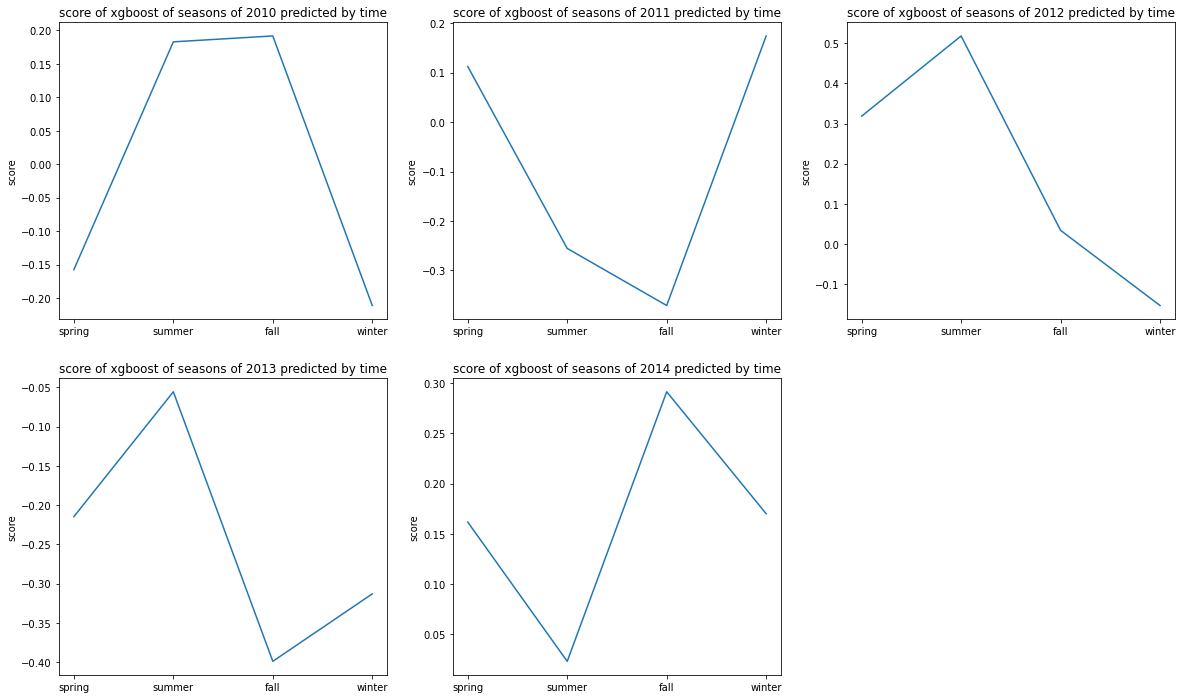

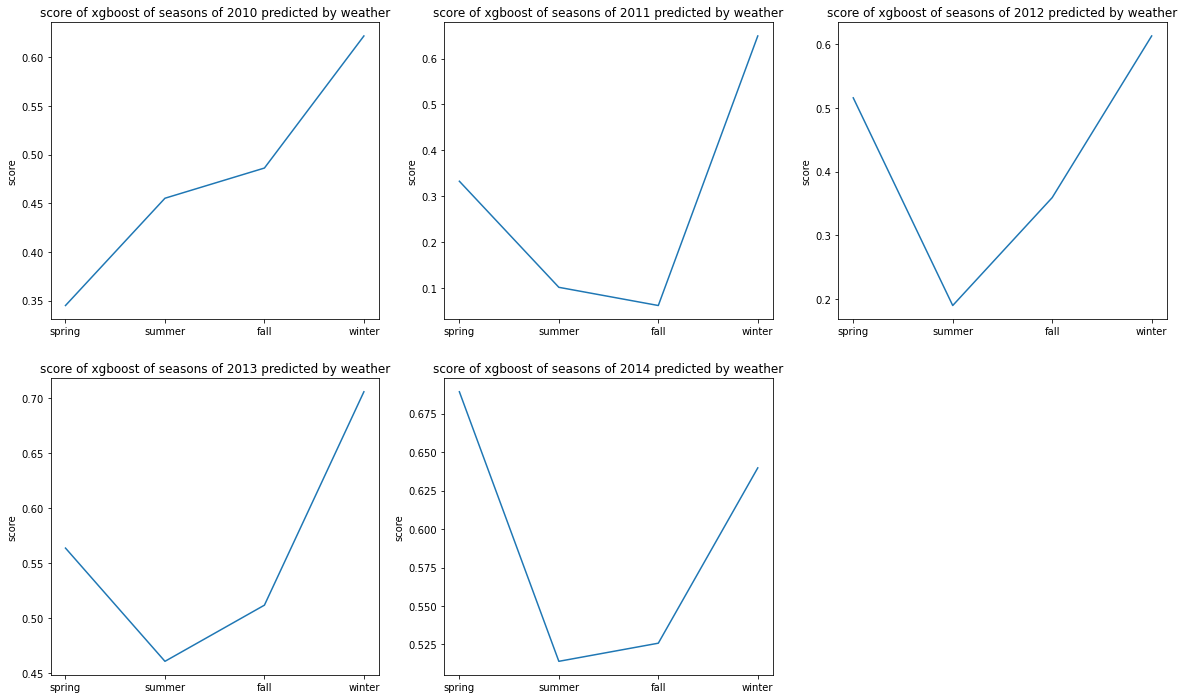

In [27]:
## 基于PM2.5在一年内四季的波动值， 用xgboost进行预测
season_of_year1=[[],[],[],[],[]]
score_of_season_weather1 = [[],[],[],[],[]]
score_of_season_time1 = [[],[],[],[],[]]

variation_of_season_time1=pd.DataFrame()
variation_of_season_weather1=pd.DataFrame()
for index, year in enumerate(Year):
   train_data_year=train_data[train_data.year==year]
   test_data_year=test_data[test_data.year==year]
   train_data_spring_year=pd.concat([train_data_year[train_data_year.month==3], train_data_year[train_data_year.month==4], train_data_year[train_data_year.month==5]],
      sort=False)
   test_data_spring_year=pd.concat([test_data_year[test_data_year.month==3], test_data_year[test_data_year.month==4], test_data_year[test_data_year.month==5]],
      sort=False)
   train_data_summer_year=pd.concat([train_data_year[train_data_year.month==6], train_data_year[train_data_year.month==7], train_data_year[train_data_year.month==8]],
      sort=False)
   test_data_summer_year=pd.concat([test_data_year[test_data_year.month==6], test_data_year[test_data_year.month==7], test_data_year[test_data_year.month==8]],
      sort=False)
   train_data_fall_year=pd.concat([train_data_year[train_data_year.month==9], train_data_year[train_data_year.month==10], train_data_year[train_data_year.month==11]],
      sort=False)
   test_data_fall_year=pd.concat([test_data_year[test_data_year.month==9], test_data_year[test_data_year.month==10], test_data_year[test_data_year.month==11]],
      sort=False)
   train_data_winter_year=pd.concat([train_data_year[train_data_year.month==12], train_data_year[train_data_year.month==1], train_data_year[train_data_year.month==2]],
      sort=False)
   test_data_winter_year=pd.concat([test_data_year[test_data_year.month==12], test_data_year[test_data_year.month==1], test_data_year[test_data_year.month==2]],
      sort=False)  
   ## Only use time to predict for spring
   X_train_data_spring_year_time = train_data_spring_year[var_time]
   X_test_data_spring_year_time = test_data_spring_year[var_time]
   y_train_data_spring_year = train_data_spring_year['pm2.5_log']
   y_test_data_spring_year = test_data_spring_year['pm2.5']
   XGB_model_time_spring=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_spring.fit(X_train_data_spring_year_time, y_train_data_spring_year)

   y_pred_spring_year_time = XGB_model_time_spring.predict(X_test_data_spring_year_time)
   y_pred_spring_year_time = np.round(np.exp(y_pred_spring_year_time)) 
   y_pred_spring_year_time = preprocessing.minmax_scale(y_pred_spring_year_time)
   y_test_data_spring_year = preprocessing.minmax_scale(y_test_data_spring_year)
   score_of_season_time1[index].append(XGB_model_time_spring.score(X_test_data_spring_year_time,test_data_spring_year['pm2.5_log']))   

   ## Only use weather to predict for spring
   X_train_data_spring_year_weather = train_data_spring_year[var_weather]
   X_test_data_spring_year_weather = test_data_spring_year[var_weather]
   XGB_model_weather_spring = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_spring.fit(X_train_data_spring_year_weather, y_train_data_spring_year)

   y_pred_spring_year_weather = XGB_model_weather_spring.predict(X_test_data_spring_year_weather)
   y_pred_spring_year_weather = np.round(np.exp(y_pred_spring_year_weather)) 
   y_pred_spring_year_weather = preprocessing.minmax_scale(y_pred_spring_year_weather)
   y_test_data_spring_year = preprocessing.minmax_scale(y_test_data_spring_year)
   score_of_season_weather1[index].append(XGB_model_weather_spring.score(X_test_data_spring_year_weather,test_data_spring_year['pm2.5_log'])) 

   ## Only use time to predict for summer
   X_train_data_summer_year_time = train_data_summer_year[var_time]
   X_test_data_summer_year_time = test_data_summer_year[var_time]
   y_train_data_summer_year = train_data_summer_year['pm2.5_log']
   y_test_data_summer_year = test_data_summer_year['pm2.5']
   XGB_model_time_summer=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_summer.fit(X_train_data_summer_year_time, y_train_data_summer_year)

   y_pred_summer_year_time = XGB_model_time_summer.predict(X_test_data_summer_year_time)
   y_pred_summer_year_time = np.round(np.exp(y_pred_summer_year_time)) 
   y_pred_summer_year_time = preprocessing.minmax_scale(y_pred_summer_year_time)
   y_test_data_summer_year = preprocessing.minmax_scale(y_test_data_summer_year)
   score_of_season_time1[index].append(XGB_model_time_summer.score(X_test_data_summer_year_time,test_data_summer_year['pm2.5_log']))   

   ## Only use weather to predict for summer
   X_train_data_summer_year_weather = train_data_summer_year[var_weather]
   X_test_data_summer_year_weather = test_data_summer_year[var_weather]
   XGB_model_weather_summer = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_summer.fit(X_train_data_summer_year_weather, y_train_data_summer_year)

   y_pred_summer_year_weather = XGB_model_weather_summer.predict(X_test_data_summer_year_weather)
   y_pred_summer_year_weather = np.round(np.exp(y_pred_summer_year_weather)) 
   y_pred_summer_year_weather = preprocessing.minmax_scale(y_pred_summer_year_weather)
   y_test_data_summer_year = preprocessing.minmax_scale(y_test_data_summer_year)
   score_of_season_weather1[index].append(XGB_model_weather_summer.score(X_test_data_summer_year_weather,test_data_summer_year['pm2.5_log']))

   ## Only use time to predict for fall
   X_train_data_fall_year_time = train_data_fall_year[var_time]
   X_test_data_fall_year_time = test_data_fall_year[var_time]
   y_train_data_fall_year = train_data_fall_year['pm2.5_log']
   y_test_data_fall_year = test_data_fall_year['pm2.5']
   XGB_model_time_fall=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_fall.fit(X_train_data_fall_year_time, y_train_data_fall_year)

   y_pred_fall_year_time = XGB_model_time_fall.predict(X_test_data_fall_year_time)
   y_pred_fall_year_time = np.round(np.exp(y_pred_fall_year_time)) 
   y_pred_fall_year_time = preprocessing.minmax_scale(y_pred_fall_year_time)
   y_test_data_fall_year = preprocessing.minmax_scale(y_test_data_fall_year)
   score_of_season_time1[index].append(XGB_model_time_fall.score(X_test_data_fall_year_time,test_data_fall_year['pm2.5_log']))   

   ## Only use weather to predict for fall
   X_train_data_fall_year_weather = train_data_fall_year[var_weather]
   X_test_data_fall_year_weather = test_data_fall_year[var_weather]
   XGB_model_weather_fall = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_fall.fit(X_train_data_fall_year_weather, y_train_data_fall_year)

   y_pred_fall_year_weather = XGB_model_weather_fall.predict(X_test_data_fall_year_weather)
   y_pred_fall_year_weather = np.round(np.exp(y_pred_fall_year_weather)) 
   y_pred_fall_year_weather = preprocessing.minmax_scale(y_pred_fall_year_weather)
   y_test_data_fall_year = preprocessing.minmax_scale(y_test_data_fall_year)
   score_of_season_weather1[index].append(XGB_model_weather_fall.score(X_test_data_fall_year_weather,test_data_fall_year['pm2.5_log']))
    

   ## Only use time to predict for winter
   X_train_data_winter_year_time = train_data_winter_year[var_time]
   X_test_data_winter_year_time = test_data_winter_year[var_time]
   y_train_data_winter_year = train_data_winter_year['pm2.5_log']
   y_test_data_winter_year = test_data_winter_year['pm2.5']
   XGB_model_time_winter=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_winter.fit(X_train_data_winter_year_time, y_train_data_winter_year)

   y_pred_winter_year_time = XGB_model_time_winter.predict(X_test_data_winter_year_time)
   y_pred_winter_year_time = np.round(np.exp(y_pred_winter_year_time)) 
   y_pred_winter_year_time = preprocessing.minmax_scale(y_pred_winter_year_time)
   y_test_data_winter_year = preprocessing.minmax_scale(y_test_data_winter_year)
   score_of_season_time1[index].append(XGB_model_time_winter.score(X_test_data_winter_year_time,test_data_winter_year['pm2.5_log']))   

   ## Only use weather to predict for winter
   X_train_data_winter_year_weather = train_data_winter_year[var_weather]
   X_test_data_winter_year_weather = test_data_winter_year[var_weather]
   XGB_model_weather_winter = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_winter.fit(X_train_data_winter_year_weather, y_train_data_winter_year)

   y_pred_winter_year_weather = XGB_model_weather_winter.predict(X_test_data_winter_year_weather)
   y_pred_winter_year_weather = np.round(np.exp(y_pred_winter_year_weather)) 
   y_pred_winter_year_weather = preprocessing.minmax_scale(y_pred_winter_year_weather)
   y_test_data_winter_year = preprocessing.minmax_scale(y_test_data_winter_year)
   score_of_season_weather1[index].append(XGB_model_weather_winter.score(X_test_data_winter_year_weather,test_data_winter_year['pm2.5_log']))

variation_of_season_time1=variation_of_season_time1.append(score_of_season_time1)
variation_of_season_weather1=variation_of_season_weather1.append(score_of_season_weather1)
plt.figure(figsize=(20,12))
Seasons=['spring','summer','fall','winter']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season_time1.iloc[i,:])
    plt.title('score of xgboost of seasons of %d predicted by time' % Year[i])
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season_weather1.iloc[i,:])
    plt.title('score of xgboost of seasons of %d predicted by weather' % Year[i])
    plt.ylabel('score')

In [28]:
variation_of_season_time1

,0,1,2,3
0,-0.157600,0.182988,0.191778,-0.211233
1,0.112579,-0.255533,-0.371047,0.174395
2,0.318417,0.517996,0.034290,-0.152796
3,-0.214718,-0.055699,-0.398923,-0.313043
4,0.161678,0.023244,0.291264,0.170026


In [29]:
variation_of_season_weather1

,0,1,2,3
0,0.345091,0.455237,0.486230,0.621849
1,0.332456,0.101059,0.061360,0.649349
2,0.515616,0.190327,0.359321,0.612537
3,0.563722,0.460768,0.511830,0.705852
4,0.689176,0.514072,0.525849,0.639737


## 与原数据相比，两种方法给出的预测分数变化趋势均有较大变化，尤其是2010年、2013年和2014年用时间因素得到的预测分数变化趋势和2011年和2013年用天气因素得到的预测分数变化趋势。但总体上，我们仍应该用天气信息进行预测，且这五年间冬天均达到最高准度，后四年夏秋两季均为最低


## 2.4.7 与task2类似，用折线图记录填补后数据每年周一早晨（6点至9点）每小时平均pm2.5的变化趋势，取每年每星期一每小时的平均浓度作为当年该天该小时的对应值

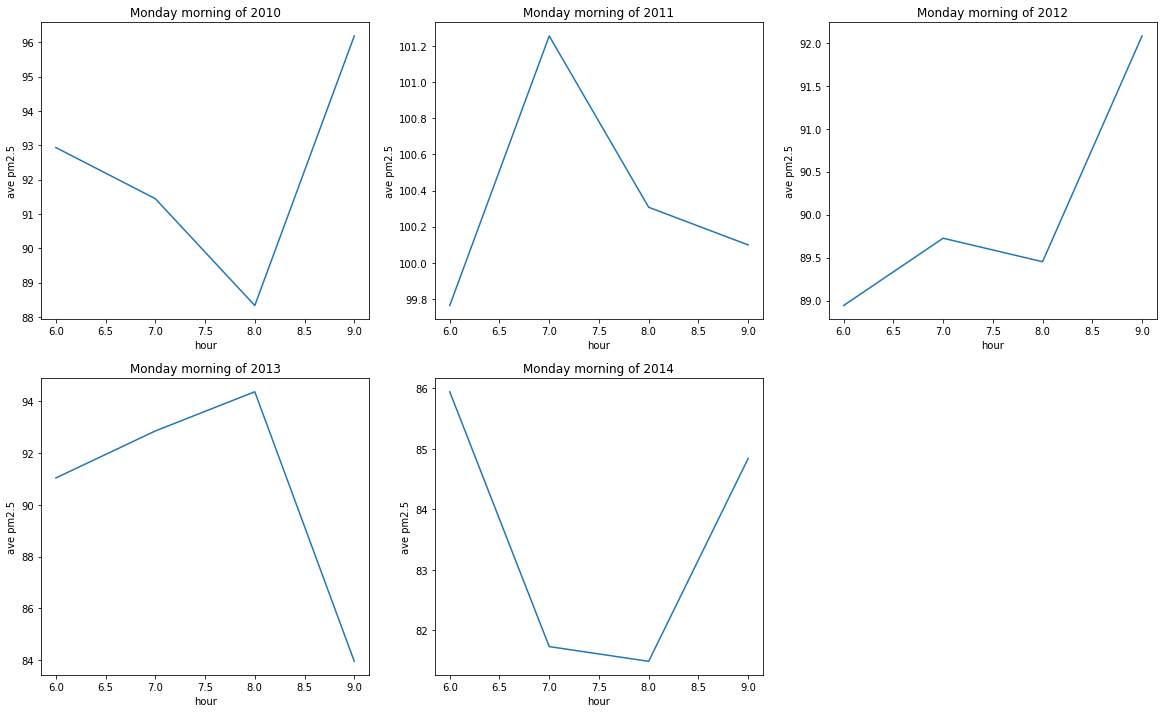

In [30]:
## PM2.5在周一上午的波动值
Hour_Mon=range(6,10)
Week_Mon=range(1)
day_of_year_Mon1=[[],[],[],[],[]]

variation_of_day_Mon1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    for week in Week_Mon:
        pm25_Mon_year=pm25_year[pm25_year.week==week]
        for hour in Hour_Mon:
            pm25_hour_year_Mon=pm25_Mon_year[pm25_Mon_year.hour==hour]
            mean=np.mean(pm25_hour_year_Mon['pm2.5'])
            day_of_year_Mon1[index].append(mean)
        
variation_of_day_Mon1=variation_of_day_Mon1.append(day_of_year_Mon1)
variation_of_day_Mon1.index=Year 

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour_Mon,variation_of_day_Mon1.iloc[i,:])
    plt.title('Monday morning of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5') 

In [31]:
variation_of_day_Mon1

,0,1,2,3
2010,92.937500,91.447115,88.336538,96.187500
2011,99.764423,101.254808,100.307692,100.099359
2012,88.943396,89.726415,89.452830,92.080189
2013,91.043269,92.860577,94.375000,83.956731
2014,85.942308,81.730769,81.487179,84.839744


## 与原数据结果相比，平均浓度数值有所变化，但变化趋势与原数据的大致相当。每年星期一早晨每小时pm2.5平均浓度变化趋势不同，但除2013和2014年外均在8点取得最低值

## 2.4.8 与task2类似，用折线图记录填补后数据每年12月周末（周六周日）晚上（18点至24点）每小时平均pm2.5的变化趋势，取每年12月周末每天每小时的平均浓度作为当年该天该小时的对应值

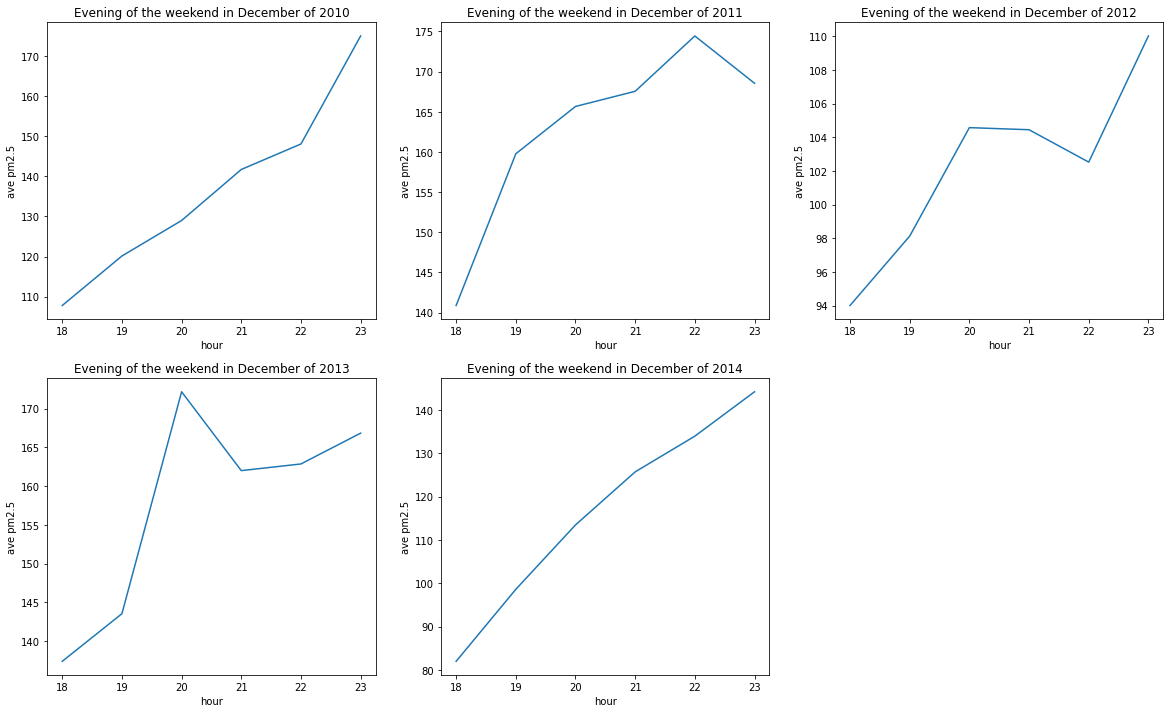

In [32]:
## PM2.5在12月周末夜晚的波动值
from pandas.core.frame import DataFrame
Hour_even=range(18,24)
week_dec=range(5,7)
month_dec=range(12,13)
weekend_Dec_2010=['2010-12-04', '2010-12-05', '2010-12-11', '2010-12-12', '2010-12-18', '2010-12-19', '2010-12-25', '2010-12-26']
weekend_Dec_2011=['2011-12-03', '2011-12-04', '2011-12-10', '2011-12-11', '2011-12-17', '2011-12-18', '2011-12-24', '2011-12-25', '2011-12-31']             
weekend_Dec_2012=['2012-12-01', '2012-12-02', '2012-12-08', '2012-12-09', '2012-12-15', '2012-12-16', '2012-12-22', '2012-12-23', '2012-12-29', '2012-12-30']             
weekend_Dec_2013=[ '2013-12-07', '2013-12-08', '2013-12-14', '2013-12-15', '2013-12-21', '2013-12-28', '2013-12-29']          
weekend_Dec_2014=['2014-12-06', '2014-12-07', '2014-12-13', '2014-12-14', '2014-12-20', '2014-12-21', '2014-12-27', '2014-12-28']             
day_of_year_Dec1=[[],[],[],[],[]]

variation_of_day_dec1=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_mean[pm25_mean.year==year]
    for month in month_dec:
        pm25_dec_year=pm25_year[pm25_year.month==month]
        pm25_weekend_dec_year=pd.concat([pm25_dec_year[pm25_dec_year.week==5], pm25_dec_year[pm25_dec_year.week==6]], sort=False)
        for hour in Hour_even:
            pm25_even_weekend_dec_year=pm25_weekend_dec_year[pm25_weekend_dec_year.hour==hour]
            mean=np.mean(pm25_even_weekend_dec_year['pm2.5'])
            day_of_year_Dec1[index].append(mean)

variation_of_day_dec1=variation_of_day_dec1.append(day_of_year_Dec1)
variation_of_day_dec1.index=Year

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour_even,variation_of_day_dec1.iloc[i,:])
    plt.title('Evening of the weekend in December of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5') 

In [33]:
variation_of_day_dec1

,0,1,2,3,4,5
2010,107.750000,120.125000,129.000000,141.750000,148.125000,175.125000
2011,140.888889,159.777778,165.666667,167.555556,174.444444,168.555556
2012,94.000000,98.125000,104.575000,104.450000,102.525000,110.025000
2013,137.416667,143.555556,172.166667,162.000000,162.861111,166.833333
2014,82.000000,98.625000,113.500000,125.750000,134.000000,144.250000


## 与原数据相比，2012年和2013年的数值有所变化，但变化趋势基本一样，平均浓度基本均为上升趋势

## 2.4.9 与task2类似，用折线图记录填补后数据每年春节期间（除夕前两天、除夕、正月初一至初七、初七后两天）每小时平均pm2.5的变化趋势，取每年春节每小时的平均浓度作为当年春节该小时的对应值

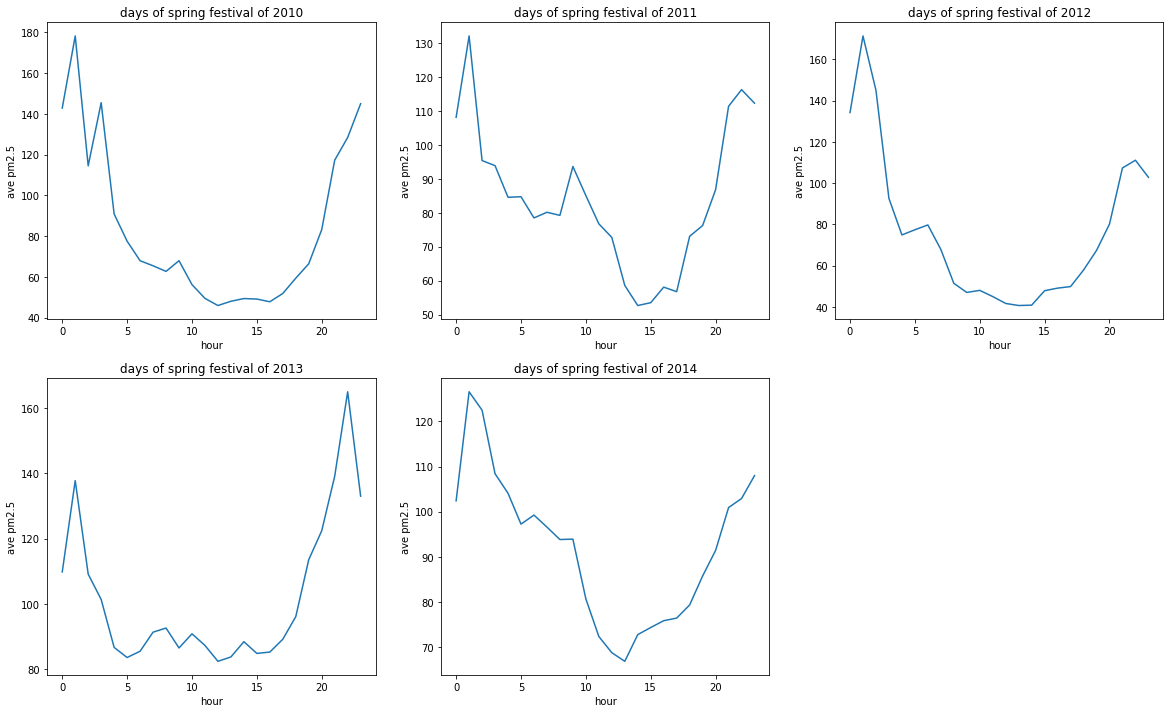

In [34]:
## PM2.5在春节每小时的波动值
Spr=range(12)
sprfest_2010 = ['2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22']
sprfest_2011 = ['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11']
sprfest_2012 = ['2012-01-20', '2012-01-21', '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29', '2012-01-30', '2012-01-31'] 
sprfest_2013 = ['2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18']   
sprfest_2014 = ['2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31', '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08'] 
hour_of_sprfest1=[[],[],[],[],[]]
variation_of_hour_sprfest1 = pd.DataFrame()

pm25_sprfest_2010=pd.DataFrame()
for sprday_2010 in sprfest_2010:
    pm25_sprfest_2010_date=pm25_mean[pm25_mean.date==sprday_2010]
    pm25_sprfest_2010=pd.concat([pm25_sprfest_2010, pm25_sprfest_2010_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2010=pm25_sprfest_2010[pm25_sprfest_2010.hour==hour]
        mean_spr_2010=np.mean(pm25_hour_sprfest_2010['pm2.5'])
        hour_of_sprfest1[0].append(mean_spr_2010)

pm25_sprfest_2011=pd.DataFrame()
for sprday_2011 in sprfest_2011:
    pm25_sprfest_2011_date=pm25_mean[pm25_mean.date==sprday_2011]
    pm25_sprfest_2011=pd.concat([pm25_sprfest_2011, pm25_sprfest_2011_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2011=pm25_sprfest_2011[pm25_sprfest_2011.hour==hour]
        mean_spr_2011=np.mean(pm25_hour_sprfest_2011['pm2.5'])
        hour_of_sprfest1[1].append(mean_spr_2011)

pm25_sprfest_2012=pd.DataFrame()
for sprday_2012 in sprfest_2012:
    pm25_sprfest_2012_date=pm25_mean[pm25_mean.date==sprday_2012]
    pm25_sprfest_2012=pd.concat([pm25_sprfest_2012, pm25_sprfest_2012_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2012=pm25_sprfest_2012[pm25_sprfest_2012.hour==hour]
        mean_spr_2012=np.mean(pm25_hour_sprfest_2012['pm2.5'])
        hour_of_sprfest1[2].append(mean_spr_2012)

pm25_sprfest_2013=pd.DataFrame()
for sprday_2013 in sprfest_2013:
    pm25_sprfest_2013_date=pm25_mean[pm25_mean.date==sprday_2013]
    pm25_sprfest_2013=pd.concat([pm25_sprfest_2013, pm25_sprfest_2013_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2013=pm25_sprfest_2013[pm25_sprfest_2013.hour==hour]
        mean_spr_2013=np.mean(pm25_hour_sprfest_2013['pm2.5'])
        hour_of_sprfest1[3].append(mean_spr_2013)

pm25_sprfest_2014=pd.DataFrame()
for sprday_2014 in sprfest_2014:
    pm25_sprfest_2014_date=pm25_mean[pm25_mean.date==sprday_2014]
    pm25_sprfest_2014=pd.concat([pm25_sprfest_2014, pm25_sprfest_2014_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2014=pm25_sprfest_2014[pm25_sprfest_2014.hour==hour]
        mean_spr_2014=np.mean(pm25_hour_sprfest_2014['pm2.5'])
        hour_of_sprfest1[4].append(mean_spr_2014) 

variation_of_hour_sprfest1=variation_of_hour_sprfest1.append(hour_of_sprfest1)

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_hour_sprfest1.iloc[i,:])
    plt.title('days of spring festival of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5')

In [35]:
variation_of_hour_sprfest1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,142.833333,178.250000,114.500000,145.500000,90.833333,77.500000,67.916667,65.416667,62.666667,67.916667,...,49.333333,49.083333,47.750000,51.833333,59.333333,66.416667,83.166667,117.250000,128.416667,145.000000
1,108.166667,132.166667,95.416667,93.916667,84.583333,84.750000,78.500000,80.166667,79.250000,93.666667,...,52.666667,53.500000,58.083333,56.750000,73.083333,76.250000,86.833333,111.416667,116.333333,112.333333
2,134.166667,171.250000,144.916667,92.583333,74.916667,77.416667,79.750000,67.916667,51.500000,47.083333,...,40.916667,47.916667,49.166667,49.916667,57.916667,67.416667,80.166667,107.333333,111.083333,102.833333
3,109.833333,137.750000,109.166667,101.416667,86.750000,83.666667,85.583333,91.416667,92.666667,86.583333,...,88.500000,84.916667,85.333333,89.250000,96.166667,113.583333,122.416667,139.083333,164.916667,133.000000
4,102.416667,126.583333,122.500000,108.416667,104.083333,97.250000,99.250000,96.583333,93.833333,93.916667,...,72.750000,74.333333,75.833333,76.416667,79.333333,85.750000,91.416667,100.916667,102.916667,108.000000


## 与原数据相比，平均浓度的数值大小和变化趋势均基本一样，每天每小时的变化趋势与全年相似，均为15点后上升，凌晨1点后慢慢下降

## 2.4.10 与task2类似，用折线图记录填补数据的每年春节期间（除夕前两天、除夕、正月初一至初七、初七后两天，以除夕前第二天为第0天）每天平均pm2.5的变化趋势，取每年春节每天的平均浓度作为当年春节该天的对应值

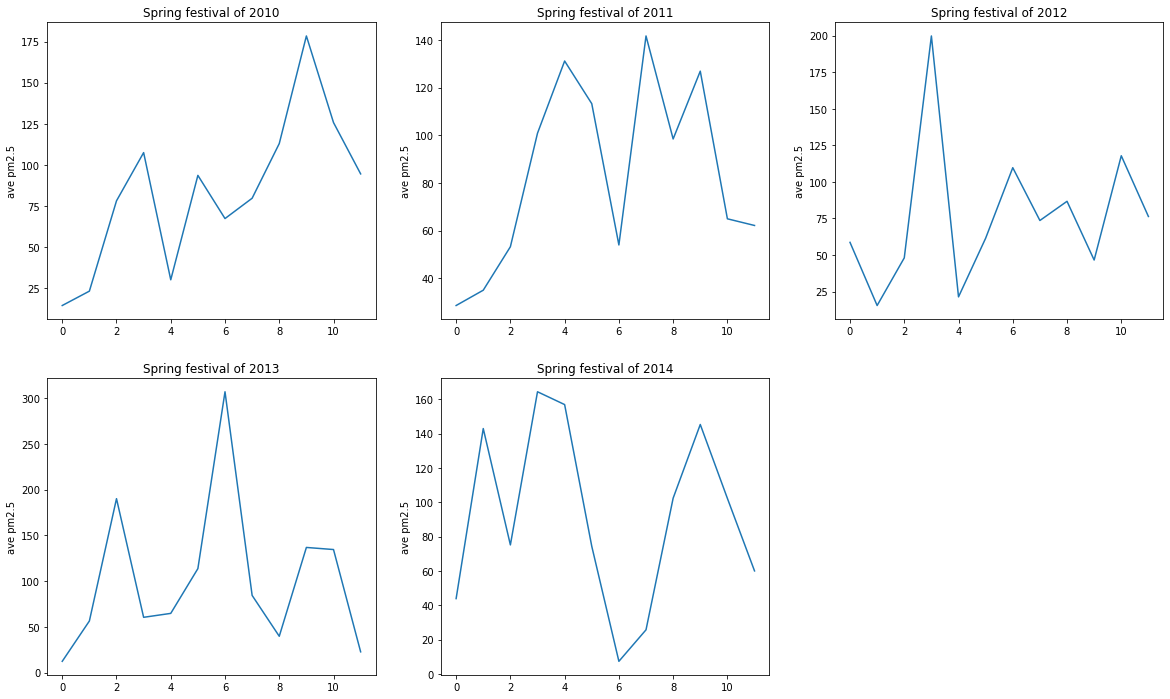

In [36]:
## PM2.5在春节每天的波动值
days_of_sprfest1=[[],[],[],[],[]]
variation_of_days_sprfest1 = pd.DataFrame()

for sprday_2010 in sprfest_2010:
    pm25_day_sprfest_2010=pm25_sprfest_2010[pm25_sprfest_2010.date==sprday_2010]
    mean_spr_2010=np.mean(pm25_day_sprfest_2010['pm2.5'])
    days_of_sprfest1[0].append(mean_spr_2010)

for sprday_2011 in sprfest_2011:
    pm25_day_sprfest_2011=pm25_sprfest_2011[pm25_sprfest_2011.date==sprday_2011]
    mean_spr_2011=np.mean(pm25_day_sprfest_2011['pm2.5'])
    days_of_sprfest1[1].append(mean_spr_2011)

for sprday_2012 in sprfest_2012:
    pm25_day_sprfest_2012=pm25_sprfest_2012[pm25_sprfest_2012.date==sprday_2012]
    mean_spr_2012=np.mean(pm25_day_sprfest_2012['pm2.5'])
    days_of_sprfest1[2].append(mean_spr_2012)

for sprday_2013 in sprfest_2013:
    pm25_day_sprfest_2013=pm25_sprfest_2013[pm25_sprfest_2013.date==sprday_2013]
    mean_spr_2013=np.mean(pm25_day_sprfest_2013['pm2.5'])
    days_of_sprfest1[3].append(mean_spr_2013)

for sprday_2014 in sprfest_2014:
    pm25_day_sprfest_2014=pm25_sprfest_2014[pm25_sprfest_2014.date==sprday_2014]
    mean_spr_2014=np.mean(pm25_day_sprfest_2014['pm2.5'])
    days_of_sprfest1[4].append(mean_spr_2014)

variation_of_days_sprfest1=variation_of_days_sprfest1.append(days_of_sprfest1)

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Spr,variation_of_days_sprfest1.iloc[i,:])
    plt.title('Spring festival of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [37]:
variation_of_days_sprfest1

,0,1,2,3,4,5,6,7,8,9,10,11
0,14.333333,23.083333,78.083333,107.458333,30.000000,93.583333,67.291667,79.666667,112.958333,178.500000,125.750000,94.500000
1,28.666667,35.083333,53.291667,100.875000,131.125000,113.250000,54.041667,141.625000,98.458333,126.875000,65.000000,62.208333
2,58.666667,15.458333,48.041667,199.875000,21.375000,61.500000,109.750000,73.625000,86.750000,46.583333,117.916667,76.375000
3,12.416667,56.458333,190.125000,60.500000,64.791667,113.708333,306.916667,84.427083,39.791667,136.833333,134.541667,22.791667
4,43.916667,142.875000,75.166667,164.291667,156.833333,74.375000,7.416667,25.750000,102.375000,145.250000,102.250000,60.041667


## 与原数据相比，平均浓度的数值大小和变化趋势均基本一样，平均浓度基本均出现3个高峰，分别在除夕前后，初三前后和初七前后

# knn填补

## 3.1 用k近邻法填补数据，设定k=40

In [38]:
pm25_data = pd.read_csv('pm25_data.csv')
date=pm25_data.date
pm25_knn = pd.DataFrame(knn_imputer(pm25_data.drop('date',axis=1)))
pm25_knn['date']=date
pm25_knn.columns = pm25_data.columns
# 对数化
pm25_knn = module.log(pm25_knn)
# 得到week
week_list=[]
for date in pm25_knn['date']:
    week_list.append(pd.to_datetime(date).weekday())
pm25_knn['week']=week_list
# 存为csv文件
pm25_knn.to_csv("pm25_data_knn.csv",index=False)
# 得到 train data & test data
test_data2, train_data2 = module.train_test_split(pm25_knn)

## 3.2 与task1类似，用xgboost预测模型拟合填补后的数据，并通过xgb.plot_importance进行特征选择

Mean squared error of test data for knn imputed data: 0.0088
R2 score: 0.6817


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

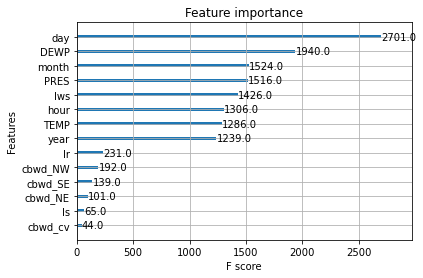

In [39]:
var=['year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_NE','cbwd_NW','cbwd_SE','cbwd_cv']
X_train2 = train_data2[var]
X_test2 = test_data2[var]
y_train2 = train_data2['pm2.5_log']
y_test2 = test_data2['pm2.5']

XGB_model2=xgb.XGBRegressor(learning_rate=0.1,n_estimators=485,max_depth=5)
XGB_model2.fit(X_train2, y_train2)
y_pred2 = XGB_model2.predict(X_test2)
y_pred2 = np.round(np.exp(y_pred2)) 

# 归一化
y_pred2=preprocessing.minmax_scale(y_pred2)
y_test2=preprocessing.minmax_scale(y_test2)
print("Mean squared error of test data for knn imputed data: %.4f" % mean_squared_error(y_pred2, y_test2))
print("R2 score: %.4f" % XGB_model2.score(X_test2,test_data2['pm2.5_log']))

# 特征选择
xgb.plot_importance(XGB_model2)

## 得到平均填补法补全的数据集的预测结果为R^2=0.6817，略低于原数据
## 筛选后day仍是最重要的特征；气象因素中仍是DEWP,lws,PRES,TEMP最重要，各个因素的重要程度不变，重要性依次为DEWP,PRES,lws,TEMP

## 3.3 与task1类似，用相关系数矩阵进行特征筛选

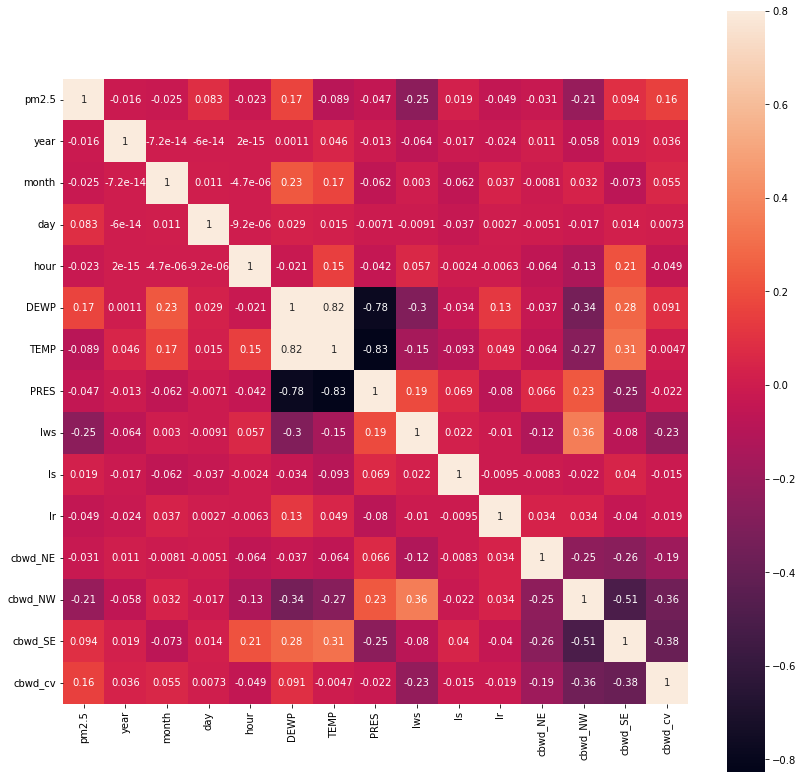

In [40]:
X2=pm25_knn[['pm2.5','year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_NE','cbwd_NW','cbwd_SE','cbwd_cv']]
corrmatrix = X2.corr()
plt.subplots(figsize=(14, 14))
sns.heatmap(corrmatrix, vmax=0.8, square=True, annot=True)
plt.show()

## 筛选后结果发生变化，与pm2.5相关性较高的因素：DEWP、lws、cbwd_NW、cbwd_cv

## 3.4 与task1类似， 通过PCA.explained_variance_ratio_选择特征并尝试降维

array([0.81476227, 0.93698415, 0.96192403, 0.97877016, 0.98886732,
       0.99506625, 0.99835893, 0.99899759, 0.99962027, 0.99980266,
       0.99988853, 0.99995792, 1.        , 1.        ])

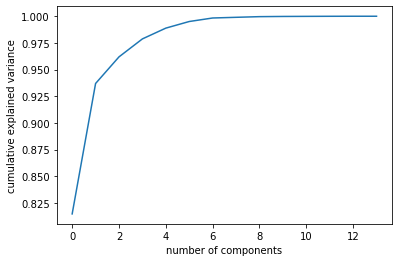

In [41]:
from sklearn.decomposition import PCA
pca2=PCA().fit(X2.drop('pm2.5',axis=1))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.cumsum(pca2.explained_variance_ratio_)

## PCA给出的结果与原数据类似，取前3个主成分作为特征，其中第一主成分主要反映了对pm2.5的影响

## 3.5 用由k近邻法得到的新数据进行task2的运行

## 3.5.1 与task2类似，用折线图记录每年一天24小时pm2.5的变化趋势，取每年每小时的平均浓度作为当年该小时的对应值

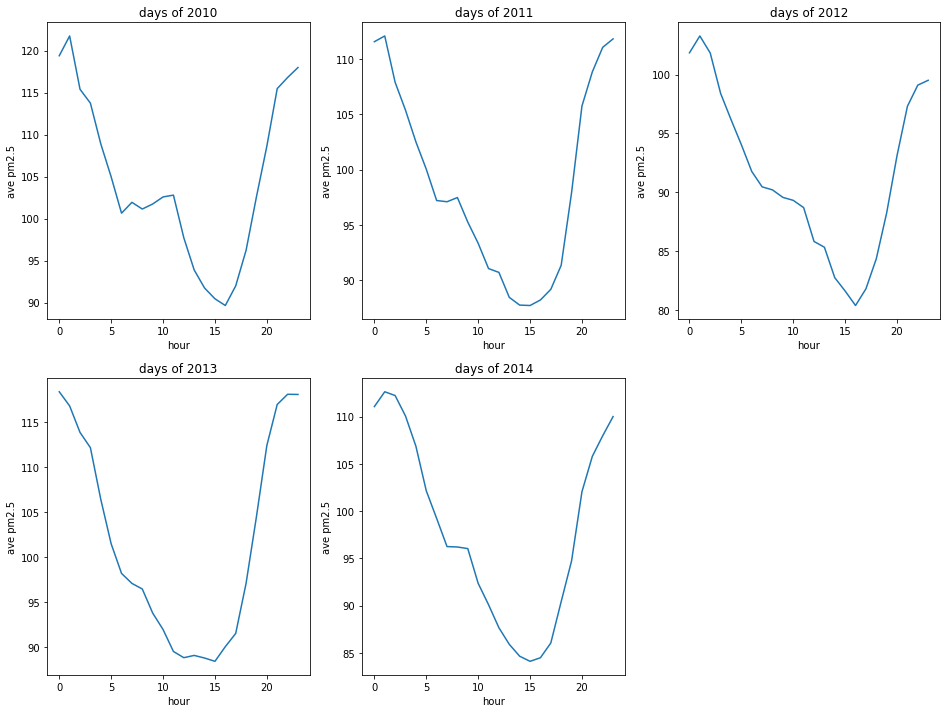

In [42]:
## PM2.5在一天内的波动值
Year=[2010,2011,2012,2013,2014]
Hour=range(24)
day_of_year2=[[],[],[],[],[]]

variation_of_day2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    for hour in Hour:
        pm25_hour_year=pm25_year[pm25_year.hour==hour]
        mean=np.mean(pm25_hour_year['pm2.5'])
        day_of_year2[index].append(mean)
        
variation_of_day2=variation_of_day2.append(day_of_year2)
variation_of_day2.index=Year    

plt.figure(figsize=(16,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day2.iloc[i,:])
    plt.title('days of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5')

In [43]:
variation_of_day2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2010,119.389110,121.742397,115.394795,113.746575,108.898699,104.968699,100.644658,101.933699,101.137055,101.737260,...,91.733630,90.451986,89.652055,91.989384,96.224452,102.597466,108.616164,115.474384,116.794658,117.983630
2011,111.560685,112.079521,107.889589,105.370959,102.509521,100.036986,97.202466,97.091507,97.470959,95.253767,...,87.748904,87.710685,88.212260,89.173082,91.345685,97.912329,105.744110,108.830411,111.051027,111.815068
2012,101.849932,103.282719,101.834904,98.404372,96.185246,94.040437,91.771175,90.461202,90.203893,89.566667,...,82.742964,81.610137,80.380123,81.795492,84.353484,88.251981,93.125410,97.308880,99.105191,99.515847
2013,118.349041,116.776781,113.838562,112.144795,106.410822,101.475822,98.189041,97.081712,96.460685,93.791986,...,88.799315,88.433425,90.062877,91.525959,97.091849,104.500959,112.385274,116.938562,118.068973,118.051781
2014,111.049110,112.616027,112.218014,110.052603,106.865137,102.147740,99.224041,96.243904,96.200137,96.028630,...,84.646370,84.107671,84.486164,86.049384,90.425822,94.730479,102.042123,105.785000,107.963356,109.991918


## 折线图结果与原数据task2的基本一样，5年间pm2.5每天的变化趋势均相似，0点至15点浓度下降，15点至24点浓度上升

## 3.5.2 与task2类似，用折线图记录每年一周每天pm2.5的变化趋势，取每年每星期一天的平均浓度作为当年该天的对应值

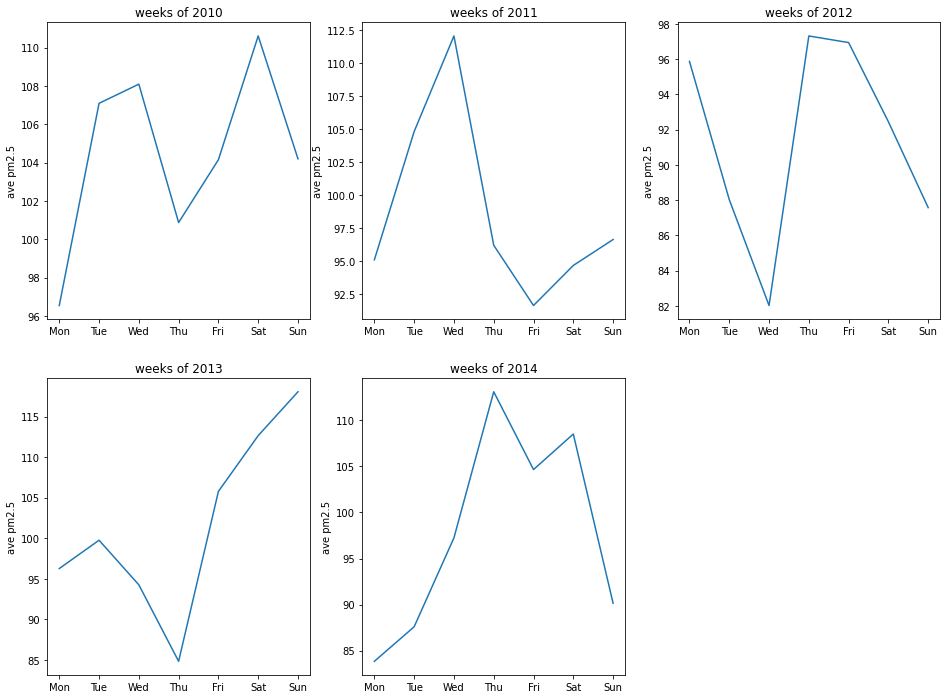

In [44]:
# PM2.5在一周的波动值
Week=range(7)
week_of_year2=[[],[],[],[],[]]

variation_of_week2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    for week in Week:
        pm25_week_year=pm25_year[pm25_year.week==week]
        mean=np.mean(pm25_week_year['pm2.5'])
        week_of_year2[index].append(mean)        
variation_of_week2=variation_of_week2.append(week_of_year2)
variation_of_week2.index=Year  

plt.figure(figsize=(16,12))
Week_str=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Week_str,variation_of_week2.iloc[i,:])
    plt.title('weeks of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [45]:
variation_of_week2

,0,1,2,3,4,5,6
2010,96.538762,107.088622,108.089764,100.867308,104.147091,110.604607,104.194071
2011,95.107151,104.830929,112.074780,96.214443,91.644611,94.679383,96.645292
2012,95.868082,88.035276,82.030849,97.310236,96.934691,92.446214,87.579383
2013,96.274299,99.764092,94.272155,84.844151,105.780669,112.652023,118.055609
2014,83.837901,87.589704,97.243829,113.106030,104.659375,108.516967,90.150040


## 与task2原数据结果相比，除少数数值外，填充的数据结果基本不变，每年每星期pm2.5平均浓度变化趋势完全不同

## 3.5.3 与task2类似，用折线图记录每年每月pm2.5的变化趋势，取每年每月的平均浓度作为当年该月的对应值

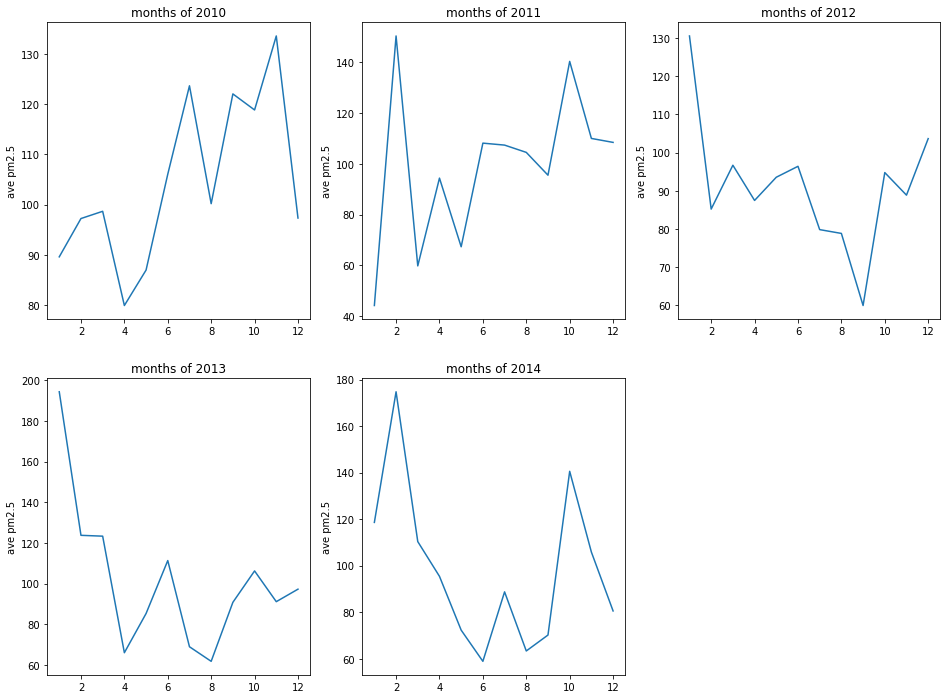

In [46]:
## PM2.5在一年内数月的波动值
Month=range(1,13)
month_of_year2=[[],[],[],[],[]]

variation_of_month2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    for month in Month:
        pm25_month_year=pm25_year[pm25_year.month==month]
        mean=np.mean(pm25_month_year['pm2.5'])
        month_of_year2[index].append(mean)        
variation_of_month2=variation_of_month2.append(month_of_year2)
variation_of_month2.index=Year 

plt.figure(figsize=(16,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month2.iloc[i,:])
    plt.title('months of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [47]:
variation_of_month2

,0,1,2,3,4,5,6,7,8,9,10,11
2010,89.613374,97.234524,98.674630,79.928681,86.979805,106.057431,123.647849,100.191364,122.033889,118.838172,133.563924,97.333333
2011,44.203730,150.321429,59.801075,94.358194,67.329704,108.126632,107.353360,104.489247,95.507083,140.301714,109.977743,108.418347
2012,130.567372,85.218139,96.708535,87.484931,93.561727,96.424028,79.840659,78.844892,59.963092,94.783065,88.869583,103.675605
2013,194.263911,123.747954,123.332023,66.079097,85.334207,111.346215,69.013441,61.853595,90.829375,106.259073,91.156736,97.295833
2014,118.634543,174.781771,110.383401,95.451319,72.326882,58.922118,88.777419,63.373589,70.219097,140.591566,105.881840,80.574630


## 结果与原数据的类似，每年每月pm2.5平均浓度变化趋势不同，但从2011年后，基本从2月到10月浓度维持在相对较低水平，而其余月份基本维持在相对较高水平

## 3.5.4 与task2类似，用折线图记录每年四季pm2.5的变化趋势，取每年每个季度的平均浓度作为当年该季度的对应值

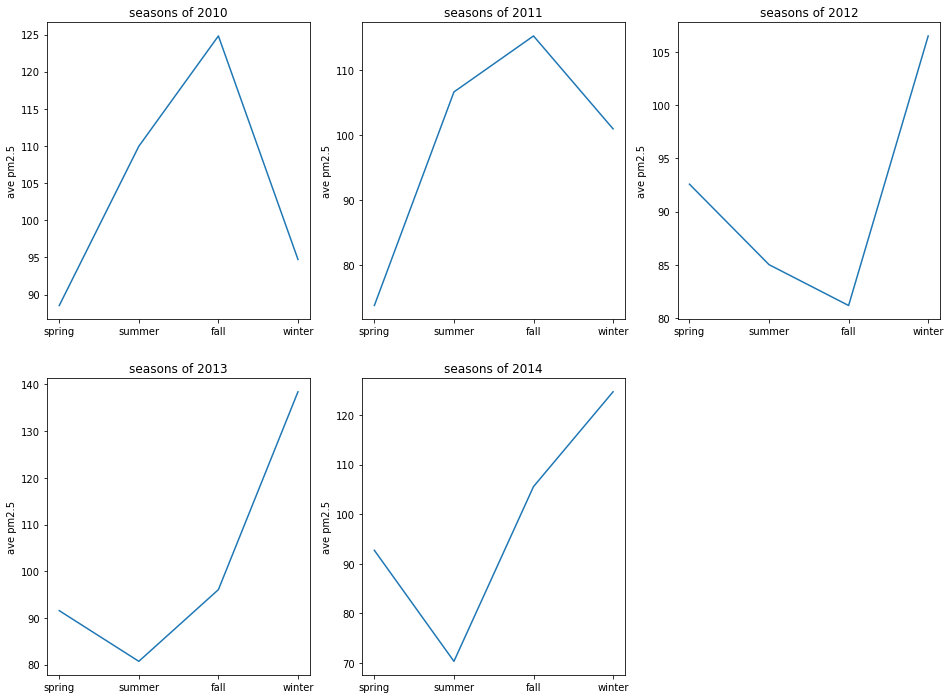

In [48]:
## PM2.5在四季的波动值
season_of_year2=[[],[],[],[],[]]

variation_of_season2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    mean_spring=(variation_of_month2.loc[year,2]+variation_of_month2.loc[year,3]+variation_of_month2.loc[year,4])/3
    mean_summer=(variation_of_month2.loc[year,5]+variation_of_month2.loc[year,6]+variation_of_month2.loc[year,7])/3
    mean_fall=(variation_of_month2.loc[year,8]+variation_of_month2.loc[year,9]+variation_of_month2.loc[year,10])/3
    mean_winter=(variation_of_month2.loc[year,11]+variation_of_month2.loc[year,0]+variation_of_month2.loc[year,1])/3
    season_of_year2[index].append(mean_spring)
    season_of_year2[index].append(mean_summer)
    season_of_year2[index].append(mean_fall)
    season_of_year2[index].append(mean_winter)   
variation_of_season2=variation_of_season2.append(season_of_year2)
variation_of_season2.index=Year   

plt.figure(figsize=(16,12))
Seasons=['spring','summer','fall','winter']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season2.iloc[i,:])
    plt.title('seasons of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [49]:
variation_of_season2

,0,1,2,3
2010,88.527705,109.965548,124.811995,94.727077
2011,73.829658,106.656413,115.262180,100.981168
2012,92.585064,85.036526,81.205247,106.487039
2013,91.581776,80.737751,96.081728,138.435899
2014,92.720534,70.357709,105.564168,124.663648


## 结果与原数据类似，除少量数值变化外，浓度变化趋势基本相同，2010年和2011年，秋季达到平均浓度最高值，浓度从春夏秋上升，秋冬下降。2012、2013、2014年夏季平均浓度最低，夏秋冬三季依次上升，浓度在冬季最高，之后下降

## 3.5.5 与task2类似，用折线图记录每年pm2.5的变化趋势，取每年平均浓度作为当年的对应值

Text(0, 0.5, 'ave pm2.5')

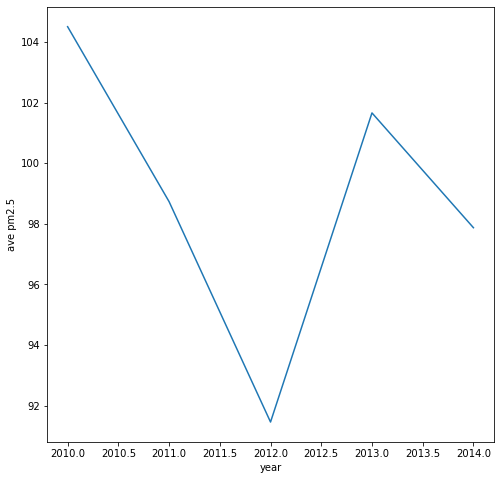

In [50]:
## PM2.5在5年内的波动值
varaition_of_year2=[]
for year in Year:
    pm25_year=pm25_knn[pm25_knn.year==year]
    mean=np.mean(pm25_year['pm2.5'])
    varaition_of_year2.append(mean) 

plt.figure(figsize=(8,8))
plt.plot(Year,varaition_of_year2)
plt.xlabel('year')
plt.ylabel('ave pm2.5')

In [51]:
varaition_of_year2

[104.50333904109645,
 98.73123858447491,
 91.4580249373719,
 101.65808219178086,
 97.87025684931508]

## 与原数据结果类似，除平均浓度数值范围有细微变化外，基本趋势不变。这五年间2012年平均浓度最低， 2010至2012年连续下降，2013年达到较高水平后2014年再次下降至2011年水平

## 3.5.6 与task2类似，对于填补后的数据，利用上述与时间有关的pm2.5平均浓度信息，分别使用每条数据的时间信息和天气信息，运用task1中提出的xgboost模型、训练集和测试集，实现对pm2.5浓度的预测，同时使用score作为预测结果好坏的测量标准，认为越接近1预测效果越好

## 3.5.6.1 与task2类似，分别使用每年一天24小时数据的时间信息和天气信息，对每小时pm2.5平均浓度进行预测，将两种方法下每年每小时的预测score用折线图分别绘出

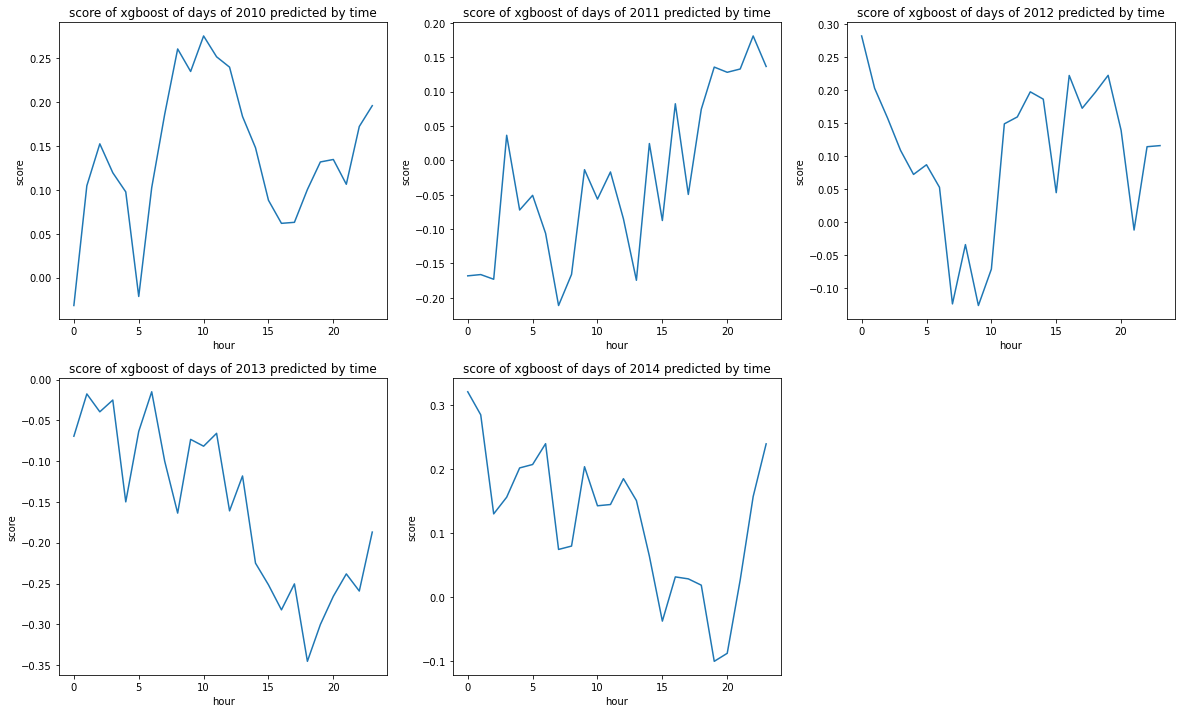

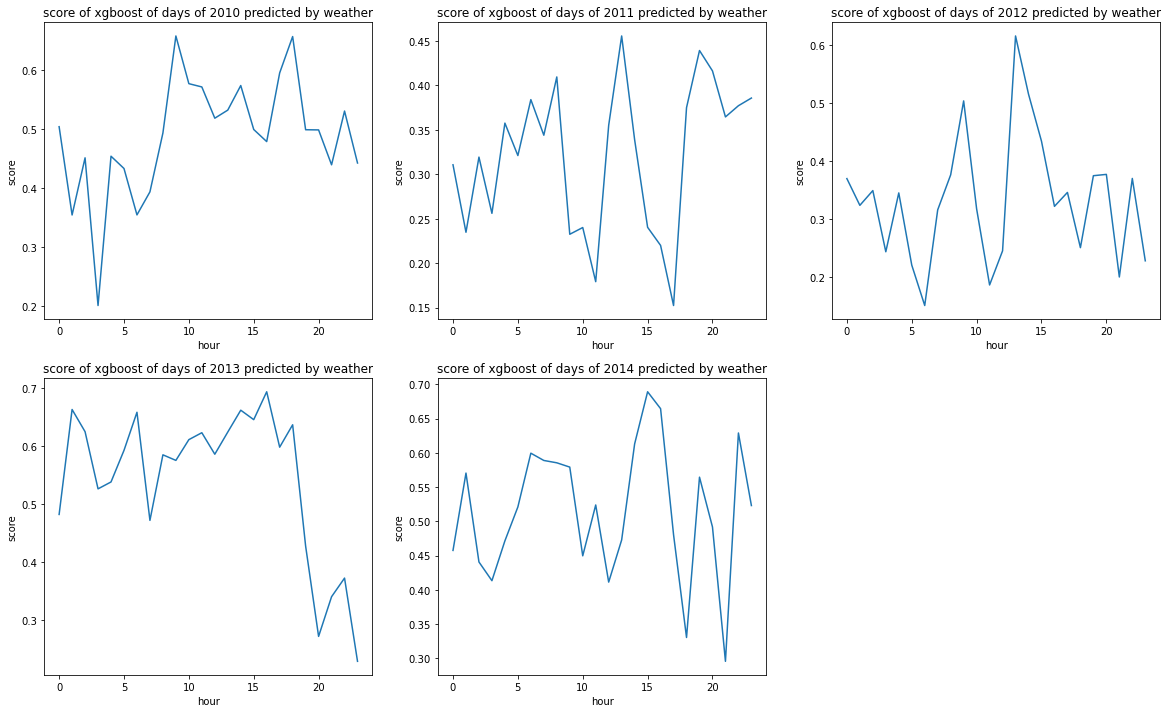

In [52]:
## 基于PM2.5在一天内的波动值，用xgboost进行预测
Year=[2010,2011,2012,2013,2014]
Hour=range(24)
day_of_year_train2=[[],[],[],[],[]]
day_of_year_test2=[[],[],[],[],[]]
score_of_year_time2 = [[],[],[],[],[]]
score_of_year_weather2 = [[],[],[],[],[]]
var_time = ['year', 'month', 'day', 'hour', 'week']
var_weather = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

variation_of_day_time2=pd.DataFrame()
variation_of_day_weather2=pd.DataFrame()
for index, year in enumerate(Year):
    train_data_year=train_data2[train_data2.year==year]
    test_data_year=test_data2[test_data2.year==year]
    for hour in Hour:
        train_data_hour_year=train_data_year[train_data_year.hour==hour]
        test_data_hour_year=test_data_year[test_data_year.hour==hour]
        
        ## Only use time to predict
        X_train_data_hour_year_time = train_data_hour_year[var_time]
        X_test_data_hour_year_time = test_data_hour_year[var_time]
        y_train_data_hour_year = train_data_hour_year['pm2.5_log']
        y_test_data_hour_year = test_data_hour_year['pm2.5']
        XGB_model_time=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_time.fit(X_train_data_hour_year_time, y_train_data_hour_year)

        y_pred_hour_year_time = XGB_model_time.predict(X_test_data_hour_year_time)
        y_pred_hour_year_time = np.round(np.exp(y_pred_hour_year_time)) 
        y_pred_hour_year_time = preprocessing.minmax_scale(y_pred_hour_year_time)
        y_test_data_hour_year = preprocessing.minmax_scale(y_test_data_hour_year)
        score_of_year_time2[index].append(XGB_model_time.score(X_test_data_hour_year_time,test_data_hour_year['pm2.5_log']))   

        ## Only use weather to predict
        X_train_data_hour_year_weather = train_data_hour_year[var_weather]
        X_test_data_hour_year_weather = test_data_hour_year[var_weather]
        XGB_model_weather = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_weather.fit(X_train_data_hour_year_weather, y_train_data_hour_year)

        y_pred_hour_year_weather = XGB_model_weather.predict(X_test_data_hour_year_weather)
        y_pred_hour_year_weather = np.round(np.exp(y_pred_hour_year_weather)) 
        y_pred_hour_year_weather = preprocessing.minmax_scale(y_pred_hour_year_weather)
        y_test_data_hour_year = preprocessing.minmax_scale(y_test_data_hour_year)
        score_of_year_weather2[index].append(XGB_model_weather.score(X_test_data_hour_year_weather,test_data_hour_year['pm2.5_log']))

variation_of_day_time2=variation_of_day_time2.append(score_of_year_time2)
variation_of_day_weather2=variation_of_day_weather2.append(score_of_year_weather2)
plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day_time2.iloc[i,:])
    plt.title('score of xgboost of days of %d predicted by time' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_day_weather2.iloc[i,:])
    plt.title('score of xgboost of days of %d predicted by weather' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('score')

In [53]:
variation_of_day_time2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.031618,0.104930,0.152678,0.119731,0.097906,-0.021305,0.102727,0.186287,0.260821,0.235165,...,0.148224,0.088328,0.062042,0.063200,0.100591,0.132016,0.134832,0.106574,0.172446,0.196174
1,-0.167985,-0.166118,-0.172948,0.036654,-0.072113,-0.050786,-0.106120,-0.211164,-0.165876,-0.013447,...,0.024629,-0.087447,0.082520,-0.049476,0.074514,0.135899,0.128328,0.133118,0.181217,0.136794
2,0.282053,0.202859,0.157611,0.108741,0.072315,0.086950,0.052803,-0.123821,-0.034006,-0.126264,...,0.186325,0.044662,0.222202,0.172540,0.196390,0.222389,0.139039,-0.011938,0.114283,0.115950
3,-0.069416,-0.017579,-0.039501,-0.025077,-0.149895,-0.063474,-0.014924,-0.099955,-0.163678,-0.073301,...,-0.225019,-0.251604,-0.282250,-0.250448,-0.345357,-0.300242,-0.265604,-0.238201,-0.259193,-0.186909
4,0.320581,0.284565,0.129793,0.155850,0.201590,0.206948,0.239477,0.074240,0.079499,0.203500,...,0.063750,-0.037770,0.031337,0.028261,0.018424,-0.100570,-0.088041,0.026573,0.156916,0.239189


In [54]:
variation_of_day_weather2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.503621,0.354045,0.450868,0.200670,0.453587,0.432782,0.354191,0.393227,0.492946,0.657331,...,0.573352,0.498873,0.478360,0.594724,0.656329,0.498465,0.498157,0.439055,0.530118,0.442082
1,0.310714,0.234868,0.319344,0.256147,0.357542,0.321090,0.383959,0.343957,0.409442,0.232616,...,0.338845,0.240443,0.220094,0.152536,0.374915,0.439147,0.416230,0.364517,0.377103,0.385732
2,0.369886,0.323870,0.349245,0.243991,0.345243,0.221078,0.151526,0.316070,0.376392,0.503559,...,0.515204,0.434201,0.322156,0.346095,0.251074,0.374850,0.377132,0.200601,0.370165,0.228422
3,0.482106,0.663538,0.625160,0.526347,0.538263,0.592868,0.658733,0.471866,0.585175,0.575543,...,0.662318,0.645985,0.694179,0.598410,0.637126,0.427483,0.271280,0.339883,0.372092,0.228199
4,0.457594,0.570431,0.440739,0.413439,0.471536,0.521032,0.599462,0.588849,0.585431,0.579162,...,0.613005,0.689071,0.664421,0.480511,0.330553,0.564468,0.491822,0.295787,0.628944,0.523064


## 相比于原数据，两种方法给出的预测分数变化趋势均与原来的相似，运用天气信息的预测准度明显更高。但2010年和2011年的这个精度相对于原数据明显下降，最高相似于原先所有训练集得到的预测模型的准度

## 3.5.6.2 与task2相似，分别使用填补后每年每月数据的时间信息和天气信息，对每月pm2.5平均浓度进行预测，将两种方法下每年每月的预测score用折线图分别绘出

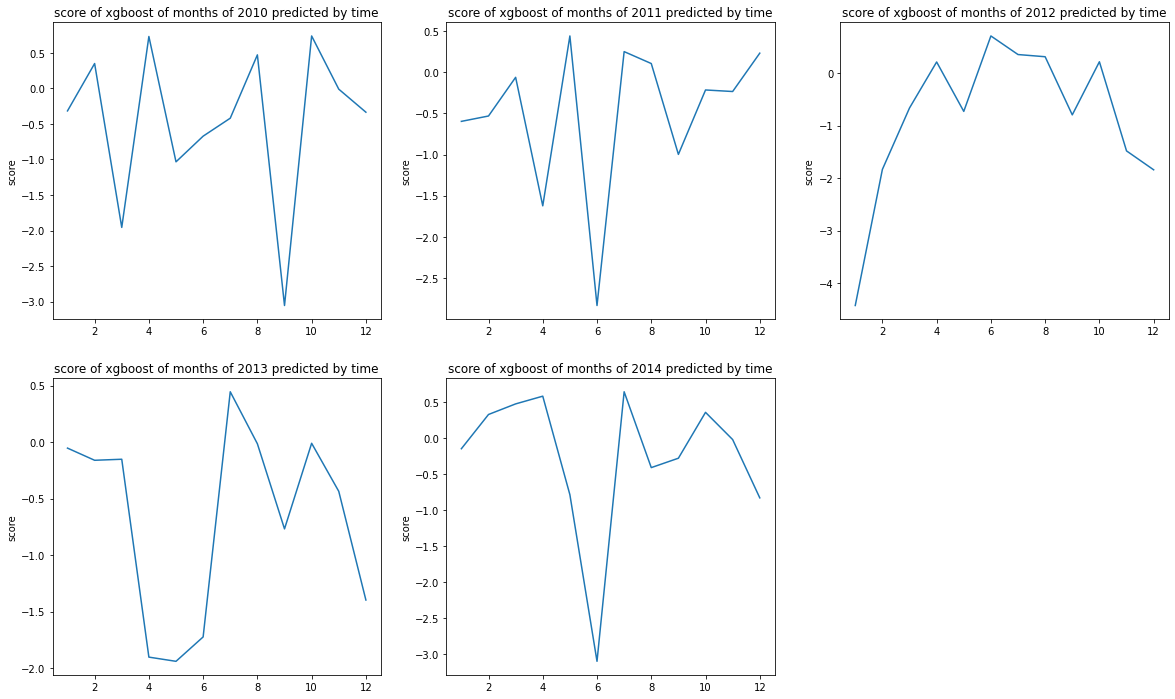

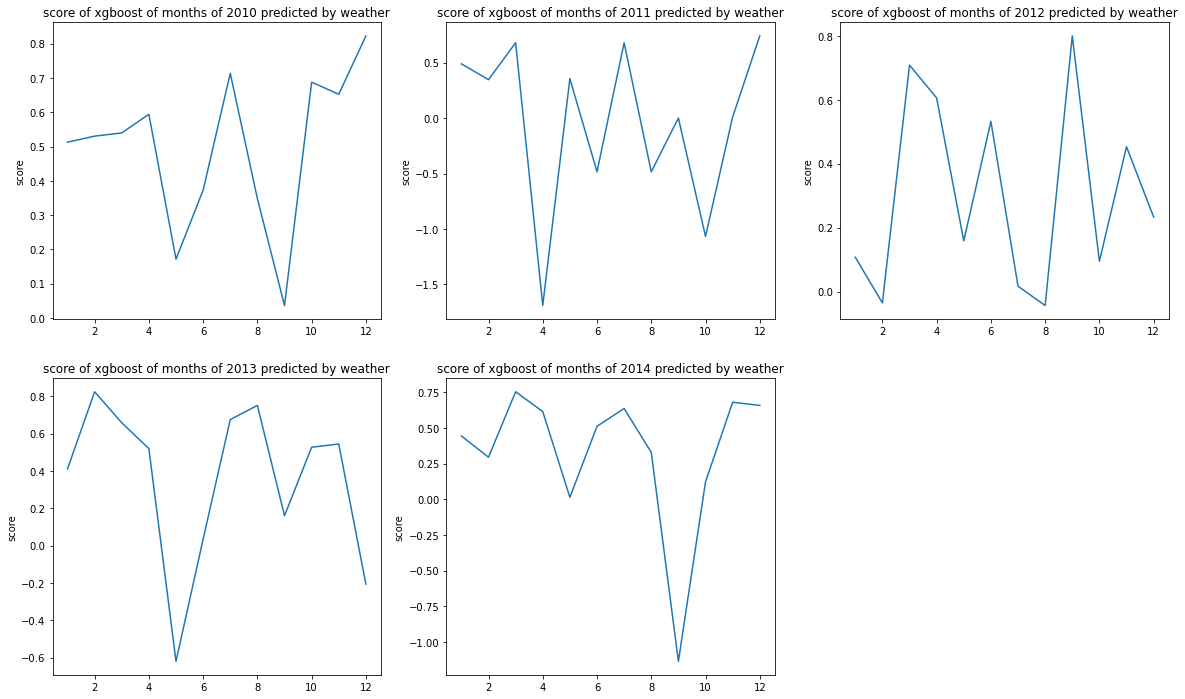

In [55]:
## 基于PM2.5在一年内数月的波动值， 用xgboost进行预测
Month = range(1,13)
week_of_year2=[[],[],[],[],[]]
score_of_month_weather2 = [[],[],[],[],[]]
score_of_month_time2 = [[],[],[],[],[]]

variation_of_month_time2=pd.DataFrame()
variation_of_month_weather2=pd.DataFrame()
for index, year in enumerate(Year):
    train_data_year=train_data2[train_data2.year==year]
    test_data_year=test_data2[test_data2.year==year]
    for month in Month:
        train_data_month_year=train_data_year[train_data_year.month==month]
        test_data_month_year=test_data_year[test_data_year.month==month]
        
        ## Only use time to predict
        X_train_data_month_year_time = train_data_month_year[var_time]
        X_test_data_month_year_time = test_data_month_year[var_time]
        y_train_data_month_year = train_data_month_year['pm2.5_log']
        y_test_data_month_year = test_data_month_year['pm2.5']
        XGB_model_time=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_time.fit(X_train_data_month_year_time, y_train_data_month_year)

        y_pred_month_year_time = XGB_model_time.predict(X_test_data_month_year_time)
        y_pred_month_year_time = np.round(np.exp(y_pred_month_year_time)) 
        y_pred_month_year_time = preprocessing.minmax_scale(y_pred_month_year_time)
        y_test_data_month_year = preprocessing.minmax_scale(y_test_data_month_year)
        score_of_month_time2[index].append(XGB_model_time.score(X_test_data_month_year_time,test_data_month_year['pm2.5_log']))   

        ## Only use weather to predict
        X_train_data_month_year_weather = train_data_month_year[var_weather]
        X_test_data_month_year_weather = test_data_month_year[var_weather]
        XGB_model_weather = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
        XGB_model_weather.fit(X_train_data_month_year_weather, y_train_data_month_year)

        y_pred_month_year_weather = XGB_model_weather.predict(X_test_data_month_year_weather)
        y_pred_month_year_weather = np.round(np.exp(y_pred_month_year_weather)) 
        y_pred_month_year_weather = preprocessing.minmax_scale(y_pred_month_year_weather)
        y_test_data_month_year = preprocessing.minmax_scale(y_test_data_month_year)
        score_of_month_weather2[index].append(XGB_model_weather.score(X_test_data_month_year_weather,test_data_month_year['pm2.5_log'])) 

variation_of_month_time2=variation_of_month_time2.append(score_of_month_time2)
variation_of_month_weather2=variation_of_month_weather2.append(score_of_month_weather2)
plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month_time2.iloc[i,:])
    plt.title('score of xgboost of months of %d predicted by time' % Year[i])
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Month,variation_of_month_weather2.iloc[i,:])
    plt.title('score of xgboost of months of %d predicted by weather' % Year[i])
    plt.ylabel('score')


In [56]:
variation_of_month_time2

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.316221,0.350750,-1.956288,0.731373,-1.033136,-0.671843,-0.418752,0.472561,-3.055587,0.738766,-0.010119,-0.334421
1,-0.595831,-0.530581,-0.060314,-1.622890,0.442669,-2.834811,0.252280,0.107309,-0.997376,-0.214049,-0.232859,0.233530
2,-4.422078,-1.832618,-0.663807,0.211765,-0.728722,0.706680,0.353052,0.311376,-0.794487,0.215700,-1.480387,-1.839974
3,-0.053715,-0.161439,-0.152277,-1.903679,-1.940888,-1.725076,0.444987,-0.015174,-0.768663,-0.010894,-0.436316,-1.398356
4,-0.149640,0.325802,0.472821,0.580061,-0.788092,-3.101852,0.641268,-0.411844,-0.281440,0.355565,-0.022349,-0.831910


In [57]:
variation_of_month_weather2

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.512649,0.530265,0.539606,0.594032,0.171647,0.372670,0.713370,0.348342,0.036332,0.687681,0.652492,0.822447
1,0.489040,0.346419,0.679294,-1.689407,0.356129,-0.484052,0.679380,-0.484138,0.000713,-1.066697,0.009812,0.740472
2,0.107470,-0.035639,0.708596,0.605793,0.158368,0.532559,0.016524,-0.043849,0.799814,0.094614,0.453076,0.232978
3,0.410739,0.824243,0.658349,0.519812,-0.619251,0.035244,0.675357,0.751243,0.160706,0.527110,0.544573,-0.205948
4,0.444732,0.295673,0.754508,0.615620,0.014118,0.512818,0.637123,0.328998,-1.135514,0.122826,0.680993,0.658794


## 相比于原数据，除2011年外，两种方法给出的预测分数变化趋势和数值均与原来的相似，用每月平均浓度预测时只用天气信息可以达到更高精度，但预测准度同样更加不稳定

## 3.5.6.3 与task2类似，分别使用填补后每年每季数据的时间信息和天气信息，对每季pm2.5平均浓度进行预测，将两种方法下每年每季的预测score用折线图分别绘出

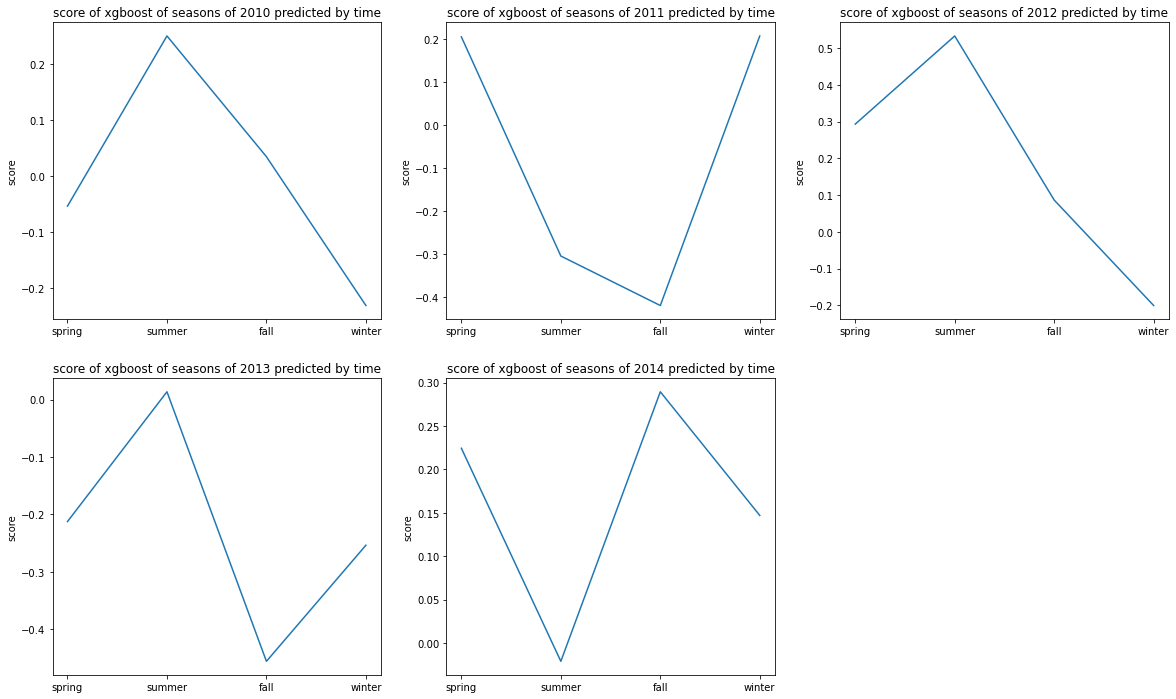

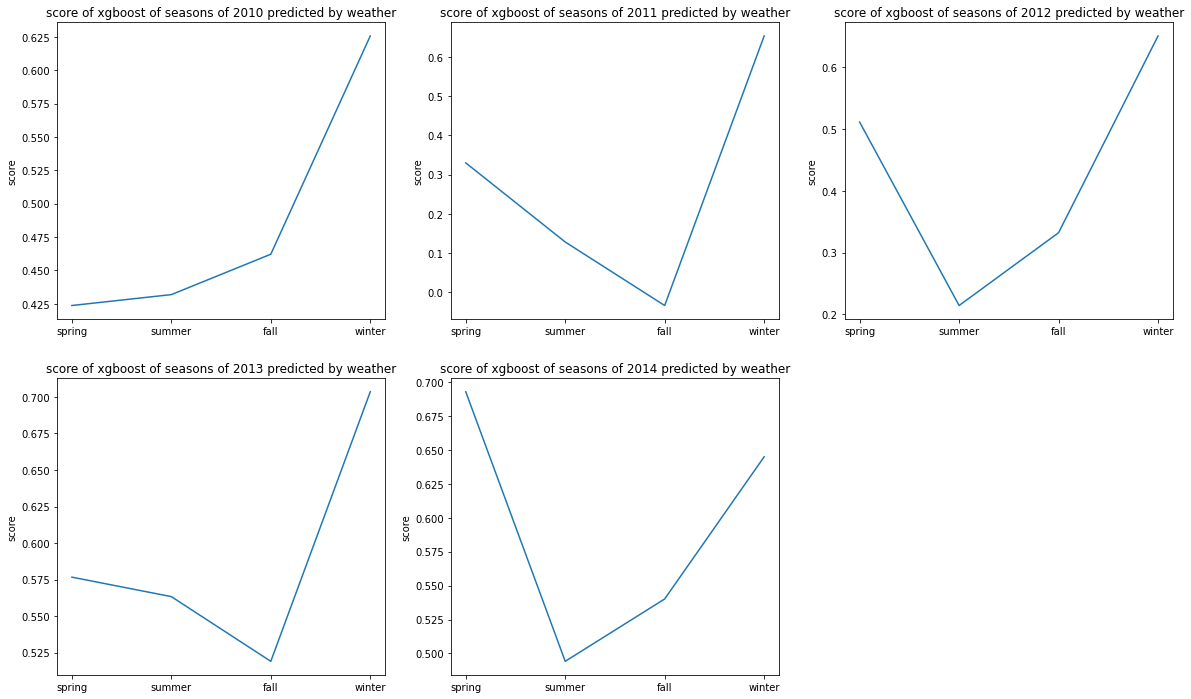

In [58]:
## 基于PM2.5在一年内四季的波动值， 用xgboost进行预测
season_of_year2=[[],[],[],[],[]]
score_of_season_weather2 = [[],[],[],[],[]]
score_of_season_time2 = [[],[],[],[],[]]

variation_of_season_time2=pd.DataFrame()
variation_of_season_weather2=pd.DataFrame()
for index, year in enumerate(Year):
   train_data_year=train_data2[train_data2.year==year]
   test_data_year=test_data2[test_data2.year==year]
   train_data_spring_year=pd.concat([train_data_year[train_data_year.month==3], train_data_year[train_data_year.month==4], train_data_year[train_data_year.month==5]],
      sort=False)
   test_data_spring_year=pd.concat([test_data_year[test_data_year.month==3], test_data_year[test_data_year.month==4], test_data_year[test_data_year.month==5]],
      sort=False)
   train_data_summer_year=pd.concat([train_data_year[train_data_year.month==6], train_data_year[train_data_year.month==7], train_data_year[train_data_year.month==8]],
      sort=False)
   test_data_summer_year=pd.concat([test_data_year[test_data_year.month==6], test_data_year[test_data_year.month==7], test_data_year[test_data_year.month==8]],
      sort=False)
   train_data_fall_year=pd.concat([train_data_year[train_data_year.month==9], train_data_year[train_data_year.month==10], train_data_year[train_data_year.month==11]],
      sort=False)
   test_data_fall_year=pd.concat([test_data_year[test_data_year.month==9], test_data_year[test_data_year.month==10], test_data_year[test_data_year.month==11]],
      sort=False)
   train_data_winter_year=pd.concat([train_data_year[train_data_year.month==12], train_data_year[train_data_year.month==1], train_data_year[train_data_year.month==2]],
      sort=False)
   test_data_winter_year=pd.concat([test_data_year[test_data_year.month==12], test_data_year[test_data_year.month==1], test_data_year[test_data_year.month==2]],
      sort=False)  
   ## Only use time to predict for spring
   X_train_data_spring_year_time = train_data_spring_year[var_time]
   X_test_data_spring_year_time = test_data_spring_year[var_time]
   y_train_data_spring_year = train_data_spring_year['pm2.5_log']
   y_test_data_spring_year = test_data_spring_year['pm2.5']
   XGB_model_time_spring=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_spring.fit(X_train_data_spring_year_time, y_train_data_spring_year)

   y_pred_spring_year_time = XGB_model_time_spring.predict(X_test_data_spring_year_time)
   y_pred_spring_year_time = np.round(np.exp(y_pred_spring_year_time)) 
   y_pred_spring_year_time = preprocessing.minmax_scale(y_pred_spring_year_time)
   y_test_data_spring_year = preprocessing.minmax_scale(y_test_data_spring_year)
   score_of_season_time2[index].append(XGB_model_time_spring.score(X_test_data_spring_year_time,test_data_spring_year['pm2.5_log']))   

   ## Only use weather to predict for spring
   X_train_data_spring_year_weather = train_data_spring_year[var_weather]
   X_test_data_spring_year_weather = test_data_spring_year[var_weather]
   XGB_model_weather_spring = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_spring.fit(X_train_data_spring_year_weather, y_train_data_spring_year)

   y_pred_spring_year_weather = XGB_model_weather_spring.predict(X_test_data_spring_year_weather)
   y_pred_spring_year_weather = np.round(np.exp(y_pred_spring_year_weather)) 
   y_pred_spring_year_weather = preprocessing.minmax_scale(y_pred_spring_year_weather)
   y_test_data_spring_year = preprocessing.minmax_scale(y_test_data_spring_year)
   score_of_season_weather2[index].append(XGB_model_weather_spring.score(X_test_data_spring_year_weather,test_data_spring_year['pm2.5_log'])) 

   ## Only use time to predict for summer
   X_train_data_summer_year_time = train_data_summer_year[var_time]
   X_test_data_summer_year_time = test_data_summer_year[var_time]
   y_train_data_summer_year = train_data_summer_year['pm2.5_log']
   y_test_data_summer_year = test_data_summer_year['pm2.5']
   XGB_model_time_summer=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_summer.fit(X_train_data_summer_year_time, y_train_data_summer_year)

   y_pred_summer_year_time = XGB_model_time_summer.predict(X_test_data_summer_year_time)
   y_pred_summer_year_time = np.round(np.exp(y_pred_summer_year_time)) 
   y_pred_summer_year_time = preprocessing.minmax_scale(y_pred_summer_year_time)
   y_test_data_summer_year = preprocessing.minmax_scale(y_test_data_summer_year)
   score_of_season_time2[index].append(XGB_model_time_summer.score(X_test_data_summer_year_time,test_data_summer_year['pm2.5_log']))   

   ## Only use weather to predict for summer
   X_train_data_summer_year_weather = train_data_summer_year[var_weather]
   X_test_data_summer_year_weather = test_data_summer_year[var_weather]
   XGB_model_weather_summer = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_summer.fit(X_train_data_summer_year_weather, y_train_data_summer_year)

   y_pred_summer_year_weather = XGB_model_weather_summer.predict(X_test_data_summer_year_weather)
   y_pred_summer_year_weather = np.round(np.exp(y_pred_summer_year_weather)) 
   y_pred_summer_year_weather = preprocessing.minmax_scale(y_pred_summer_year_weather)
   y_test_data_summer_year = preprocessing.minmax_scale(y_test_data_summer_year)
   score_of_season_weather2[index].append(XGB_model_weather_summer.score(X_test_data_summer_year_weather,test_data_summer_year['pm2.5_log']))

   ## Only use time to predict for fall
   X_train_data_fall_year_time = train_data_fall_year[var_time]
   X_test_data_fall_year_time = test_data_fall_year[var_time]
   y_train_data_fall_year = train_data_fall_year['pm2.5_log']
   y_test_data_fall_year = test_data_fall_year['pm2.5']
   XGB_model_time_fall=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_fall.fit(X_train_data_fall_year_time, y_train_data_fall_year)

   y_pred_fall_year_time = XGB_model_time_fall.predict(X_test_data_fall_year_time)
   y_pred_fall_year_time = np.round(np.exp(y_pred_fall_year_time)) 
   y_pred_fall_year_time = preprocessing.minmax_scale(y_pred_fall_year_time)
   y_test_data_fall_year = preprocessing.minmax_scale(y_test_data_fall_year)
   score_of_season_time2[index].append(XGB_model_time_fall.score(X_test_data_fall_year_time,test_data_fall_year['pm2.5_log']))   

   ## Only use weather to predict for fall
   X_train_data_fall_year_weather = train_data_fall_year[var_weather]
   X_test_data_fall_year_weather = test_data_fall_year[var_weather]
   XGB_model_weather_fall = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_fall.fit(X_train_data_fall_year_weather, y_train_data_fall_year)

   y_pred_fall_year_weather = XGB_model_weather_fall.predict(X_test_data_fall_year_weather)
   y_pred_fall_year_weather = np.round(np.exp(y_pred_fall_year_weather)) 
   y_pred_fall_year_weather = preprocessing.minmax_scale(y_pred_fall_year_weather)
   y_test_data_fall_year = preprocessing.minmax_scale(y_test_data_fall_year)
   score_of_season_weather2[index].append(XGB_model_weather_fall.score(X_test_data_fall_year_weather,test_data_fall_year['pm2.5_log']))
    

   ## Only use time to predict for winter
   X_train_data_winter_year_time = train_data_winter_year[var_time]
   X_test_data_winter_year_time = test_data_winter_year[var_time]
   y_train_data_winter_year = train_data_winter_year['pm2.5_log']
   y_test_data_winter_year = test_data_winter_year['pm2.5']
   XGB_model_time_winter=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_time_winter.fit(X_train_data_winter_year_time, y_train_data_winter_year)

   y_pred_winter_year_time = XGB_model_time_winter.predict(X_test_data_winter_year_time)
   y_pred_winter_year_time = np.round(np.exp(y_pred_winter_year_time)) 
   y_pred_winter_year_time = preprocessing.minmax_scale(y_pred_winter_year_time)
   y_test_data_winter_year = preprocessing.minmax_scale(y_test_data_winter_year)
   score_of_season_time2[index].append(XGB_model_time_winter.score(X_test_data_winter_year_time,test_data_winter_year['pm2.5_log']))   

   ## Only use weather to predict for winter
   X_train_data_winter_year_weather = train_data_winter_year[var_weather]
   X_test_data_winter_year_weather = test_data_winter_year[var_weather]
   XGB_model_weather_winter = XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=5)
   XGB_model_weather_winter.fit(X_train_data_winter_year_weather, y_train_data_winter_year)

   y_pred_winter_year_weather = XGB_model_weather_winter.predict(X_test_data_winter_year_weather)
   y_pred_winter_year_weather = np.round(np.exp(y_pred_winter_year_weather)) 
   y_pred_winter_year_weather = preprocessing.minmax_scale(y_pred_winter_year_weather)
   y_test_data_winter_year = preprocessing.minmax_scale(y_test_data_winter_year)
   score_of_season_weather2[index].append(XGB_model_weather_winter.score(X_test_data_winter_year_weather,test_data_winter_year['pm2.5_log']))

variation_of_season_time2=variation_of_season_time2.append(score_of_season_time2)
variation_of_season_weather2=variation_of_season_weather2.append(score_of_season_weather2)
plt.figure(figsize=(20,12))
Seasons=['spring','summer','fall','winter']

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season_time2.iloc[i,:])
    plt.title('score of xgboost of seasons of %d predicted by time' % Year[i])
    plt.ylabel('score')

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Seasons,variation_of_season_weather2.iloc[i,:])
    plt.title('score of xgboost of seasons of %d predicted by weather' % Year[i])
    plt.ylabel('score')

In [59]:
variation_of_season_time2

,0,1,2,3
0,-0.053397,0.250622,0.034900,-0.231000
1,0.206036,-0.304031,-0.419166,0.208167
2,0.293157,0.532885,0.086612,-0.200190
3,-0.212515,0.013631,-0.455976,-0.253727
4,0.224382,-0.020966,0.289419,0.147010


In [60]:
variation_of_season_weather2

,0,1,2,3
0,0.423770,0.431937,0.462179,0.625654
1,0.330039,0.128335,-0.033568,0.653581
2,0.511483,0.214293,0.332253,0.651084
3,0.576672,0.563351,0.519068,0.703538
4,0.693078,0.494148,0.540176,0.645097


## 与原数据相比，两种方法给出的预测分数变化趋势均有较大变化，尤其是2013年用时间因素得到的预测分数变化趋势和2011年和2013年用天气因素得到的预测分数变化趋势。但总体上，我们仍应该用天气信息进行预测，且这五年间冬天均达到最高准度，后四年夏秋两季均为最低

## 3.5.7 与task2类似，用折线图记录填补后数据每年周一早晨（6点至9点）每小时平均pm2.5的变化趋势，取每年每星期一每小时的平均浓度作为当年该天该小时的对应值

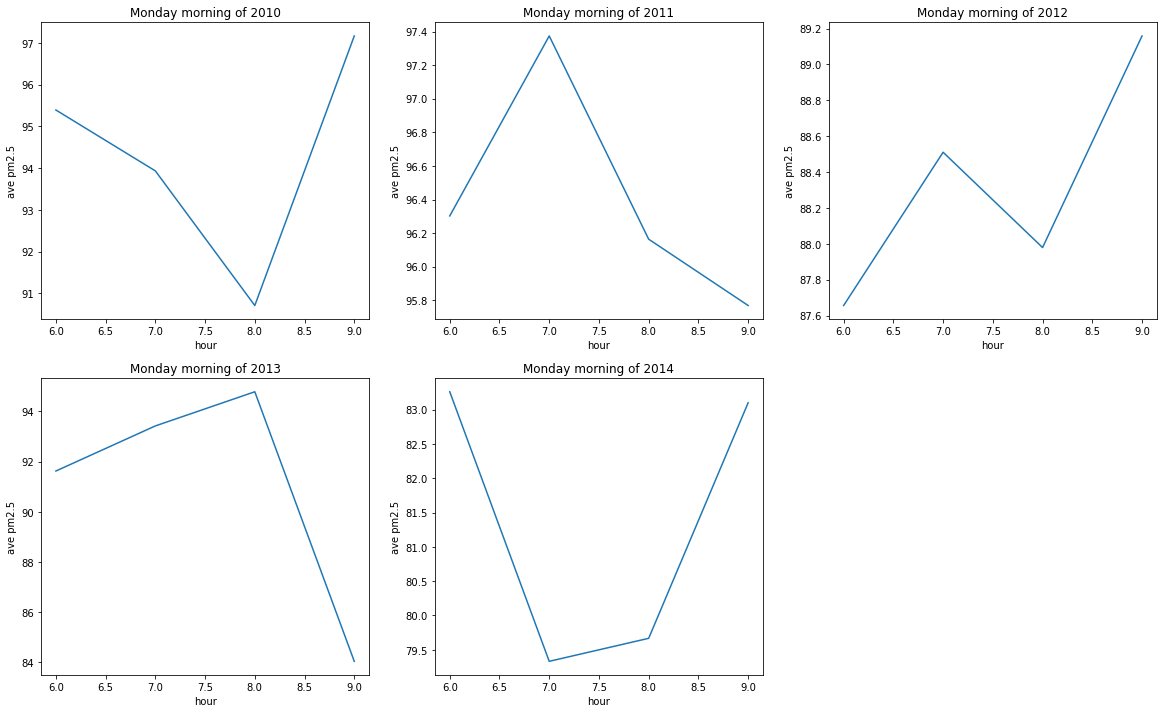

In [61]:
## PM2.5在周一上午的波动值
Hour_Mon=range(6,10)
Week_Mon=range(1)
day_of_year_Mon2=[[],[],[],[],[]]

variation_of_day_Mon2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    for week in Week_Mon:
        pm25_Mon_year=pm25_year[pm25_year.week==week]
        for hour in Hour_Mon:
            pm25_hour_year_Mon=pm25_Mon_year[pm25_Mon_year.hour==hour]
            mean=np.mean(pm25_hour_year_Mon['pm2.5'])
            day_of_year_Mon2[index].append(mean)
        
variation_of_day_Mon2=variation_of_day_Mon2.append(day_of_year_Mon2)
variation_of_day_Mon2.index=Year 

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour_Mon,variation_of_day_Mon2.iloc[i,:])
    plt.title('Monday morning of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5') 

In [62]:
variation_of_day_Mon2

,0,1,2,3
2010,95.391827,93.933654,90.710577,97.164423
2011,96.302404,97.373558,96.163942,95.769231
2012,87.656132,88.510377,87.979245,89.158491
2013,91.625000,93.421154,94.781731,84.046154
2014,83.258654,79.332212,79.667308,83.098558


## 与原数据结果相比，平均浓度数值和变化趋势与原数据的大致相当。每年星期一早晨每小时pm2.5平均浓度变化趋势不同，但除2013年外均在8点取得最低值

## 3.5.8 与task2类似，用折线图记录填补后数据每年12月周末（周六周日）晚上（18点至24点）每小时平均pm2.5的变化趋势，取每年12月周末每天每小时的平均浓度作为当年该天该小时的对应值

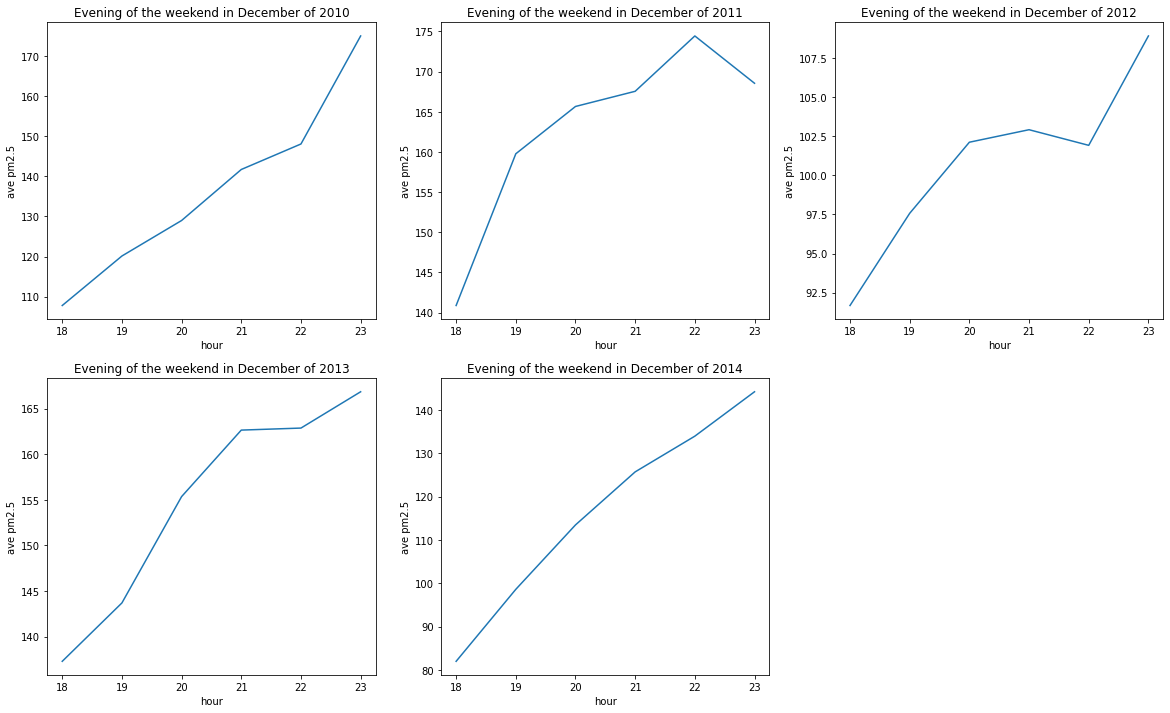

In [63]:
## PM2.5在12月周末夜晚的波动值
from pandas.core.frame import DataFrame
Hour_even=range(18,24)
week_dec=range(5,7)
month_dec=range(12,13)
weekend_Dec_2010=['2010-12-04', '2010-12-05', '2010-12-11', '2010-12-12', '2010-12-18', '2010-12-19', '2010-12-25', '2010-12-26']
weekend_Dec_2011=['2011-12-03', '2011-12-04', '2011-12-10', '2011-12-11', '2011-12-17', '2011-12-18', '2011-12-24', '2011-12-25', '2011-12-31']             
weekend_Dec_2012=['2012-12-01', '2012-12-02', '2012-12-08', '2012-12-09', '2012-12-15', '2012-12-16', '2012-12-22', '2012-12-23', '2012-12-29', '2012-12-30']             
weekend_Dec_2013=[ '2013-12-07', '2013-12-08', '2013-12-14', '2013-12-15', '2013-12-21', '2013-12-28', '2013-12-29']          
weekend_Dec_2014=['2014-12-06', '2014-12-07', '2014-12-13', '2014-12-14', '2014-12-20', '2014-12-21', '2014-12-27', '2014-12-28']             
day_of_year_Dec2=[[],[],[],[],[]]

variation_of_day_dec2=pd.DataFrame()
for index, year in enumerate(Year):
    pm25_year=pm25_knn[pm25_knn.year==year]
    for month in month_dec:
        pm25_dec_year=pm25_year[pm25_year.month==month]
        pm25_weekend_dec_year=pd.concat([pm25_dec_year[pm25_dec_year.week==5], pm25_dec_year[pm25_dec_year.week==6]], sort=False)
        for hour in Hour_even:
            pm25_even_weekend_dec_year=pm25_weekend_dec_year[pm25_weekend_dec_year.hour==hour]
            mean=np.mean(pm25_even_weekend_dec_year['pm2.5'])
            day_of_year_Dec2[index].append(mean)

variation_of_day_dec2=variation_of_day_dec2.append(day_of_year_Dec2)
variation_of_day_dec2.index=Year

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour_even,variation_of_day_dec2.iloc[i,:])
    plt.title('Evening of the weekend in December of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5') 

In [64]:
variation_of_day_dec2

,0,1,2,3,4,5
2010,107.750000,120.125000,129.000000,141.750000,148.125000,175.125000
2011,140.888889,159.777778,165.666667,167.555556,174.444444,168.555556
2012,91.675000,97.575000,102.125000,102.925000,101.925000,108.925000
2013,137.277778,143.686111,155.352778,162.650000,162.872222,166.855556
2014,82.000000,98.625000,113.500000,125.750000,134.000000,144.250000


## 与原数据相比，2013年的数值有较大变化，但变化趋势基本一样，平均浓度基本均为上升趋势

## 3.5.9 与task2类似，用折线图记录填补后数据每年春节期间（除夕前两天、除夕、正月初一至初七、初七后两天）每小时平均pm2.5的变化趋势，取每年春节每小时的平均浓度作为当年春节该小时的对应值

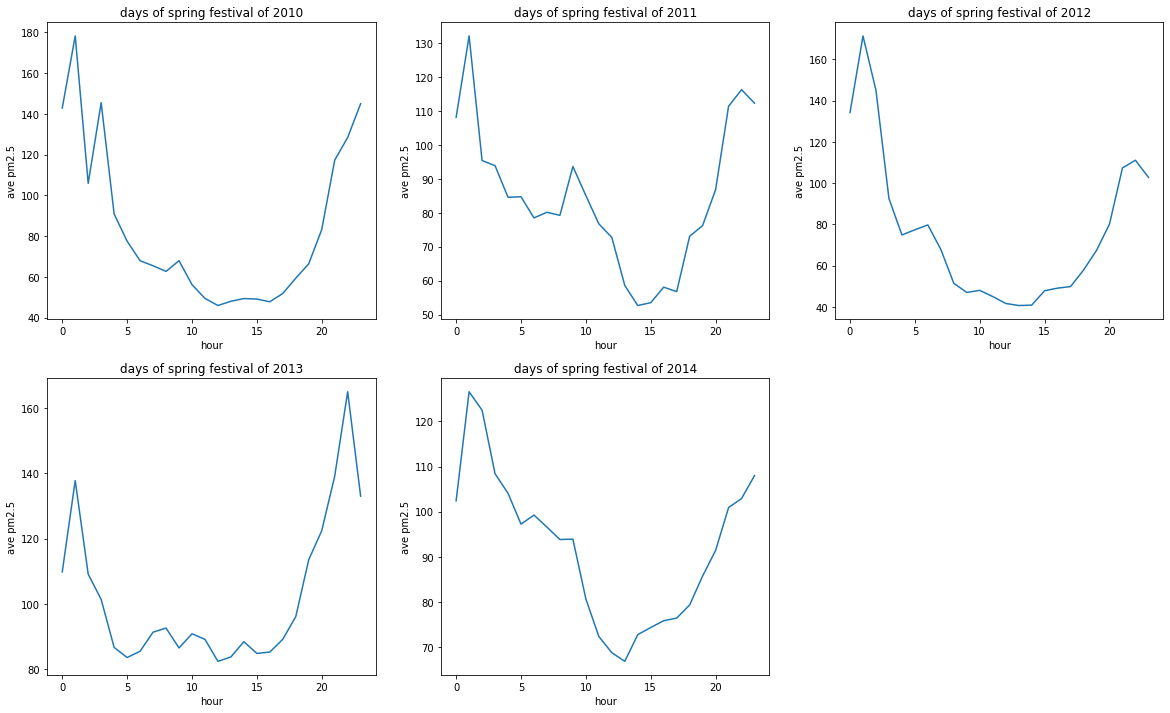

In [65]:
## PM2.5在春节每小时的波动值
Spr=range(12)
sprfest_2010 = ['2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22']
sprfest_2011 = ['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11']
sprfest_2012 = ['2012-01-20', '2012-01-21', '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29', '2012-01-30', '2012-01-31'] 
sprfest_2013 = ['2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18']   
sprfest_2014 = ['2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31', '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08'] 
hour_of_sprfest2=[[],[],[],[],[]]
variation_of_hour_sprfest2 = pd.DataFrame()

pm25_sprfest_2010=pd.DataFrame()
for sprday_2010 in sprfest_2010:
    pm25_sprfest_2010_date=pm25_knn[pm25_knn.date==sprday_2010]
    pm25_sprfest_2010=pd.concat([pm25_sprfest_2010, pm25_sprfest_2010_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2010=pm25_sprfest_2010[pm25_sprfest_2010.hour==hour]
        mean_spr_2010=np.mean(pm25_hour_sprfest_2010['pm2.5'])
        hour_of_sprfest2[0].append(mean_spr_2010)

pm25_sprfest_2011=pd.DataFrame()
for sprday_2011 in sprfest_2011:
    pm25_sprfest_2011_date=pm25_knn[pm25_knn.date==sprday_2011]
    pm25_sprfest_2011=pd.concat([pm25_sprfest_2011, pm25_sprfest_2011_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2011=pm25_sprfest_2011[pm25_sprfest_2011.hour==hour]
        mean_spr_2011=np.mean(pm25_hour_sprfest_2011['pm2.5'])
        hour_of_sprfest2[1].append(mean_spr_2011)

pm25_sprfest_2012=pd.DataFrame()
for sprday_2012 in sprfest_2012:
    pm25_sprfest_2012_date=pm25_knn[pm25_knn.date==sprday_2012]
    pm25_sprfest_2012=pd.concat([pm25_sprfest_2012, pm25_sprfest_2012_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2012=pm25_sprfest_2012[pm25_sprfest_2012.hour==hour]
        mean_spr_2012=np.mean(pm25_hour_sprfest_2012['pm2.5'])
        hour_of_sprfest2[2].append(mean_spr_2012)

pm25_sprfest_2013=pd.DataFrame()
for sprday_2013 in sprfest_2013:
    pm25_sprfest_2013_date=pm25_knn[pm25_knn.date==sprday_2013]
    pm25_sprfest_2013=pd.concat([pm25_sprfest_2013, pm25_sprfest_2013_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2013=pm25_sprfest_2013[pm25_sprfest_2013.hour==hour]
        mean_spr_2013=np.mean(pm25_hour_sprfest_2013['pm2.5'])
        hour_of_sprfest2[3].append(mean_spr_2013)

pm25_sprfest_2014=pd.DataFrame()
for sprday_2014 in sprfest_2014:
    pm25_sprfest_2014_date=pm25_knn[pm25_knn.date==sprday_2014]
    pm25_sprfest_2014=pd.concat([pm25_sprfest_2014, pm25_sprfest_2014_date], sort=False)
for hour in Hour:
        pm25_hour_sprfest_2014=pm25_sprfest_2014[pm25_sprfest_2014.hour==hour]
        mean_spr_2014=np.mean(pm25_hour_sprfest_2014['pm2.5'])
        hour_of_sprfest2[4].append(mean_spr_2014) 

variation_of_hour_sprfest2=variation_of_hour_sprfest2.append(hour_of_sprfest2)

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Hour,variation_of_hour_sprfest2.iloc[i,:])
    plt.title('days of spring festival of %d' % Year[i])
    plt.xlabel('hour')
    plt.ylabel('ave pm2.5')

In [66]:
variation_of_hour_sprfest2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,142.833333,178.250000,105.883333,145.500000,90.833333,77.500000,67.916667,65.416667,62.666667,67.916667,...,49.333333,49.083333,47.750000,51.833333,59.333333,66.416667,83.166667,117.250000,128.416667,145.000000
1,108.166667,132.166667,95.416667,93.916667,84.583333,84.750000,78.500000,80.166667,79.250000,93.666667,...,52.666667,53.500000,58.083333,56.750000,73.083333,76.250000,86.833333,111.416667,116.333333,112.333333
2,134.166667,171.250000,144.916667,92.583333,74.916667,77.416667,79.750000,67.916667,51.500000,47.083333,...,40.916667,47.916667,49.166667,49.916667,57.916667,67.416667,80.166667,107.333333,111.083333,102.833333
3,109.833333,137.750000,109.166667,101.416667,86.750000,83.666667,85.583333,91.416667,92.666667,86.583333,...,88.500000,84.916667,85.333333,89.250000,96.166667,113.583333,122.416667,139.083333,164.916667,133.000000
4,102.416667,126.583333,122.500000,108.416667,104.083333,97.250000,99.250000,96.583333,93.833333,93.916667,...,72.750000,74.333333,75.833333,76.416667,79.333333,85.750000,91.416667,100.916667,102.916667,108.000000


## 与原数据相比，平均浓度的数值大小和变化趋势均基本一样，每天每小时的变化趋势与全年相似，均为15点后上升，凌晨1点后慢慢下降

## 3.5.10 与task2类似，用折线图记录填补数据的每年春节期间（除夕前两天、除夕、正月初一至初七、初七后两天，以除夕前第二天为第0天）每天平均pm2.5的变化趋势，取每年春节每天的平均浓度作为当年春节该天的对应值

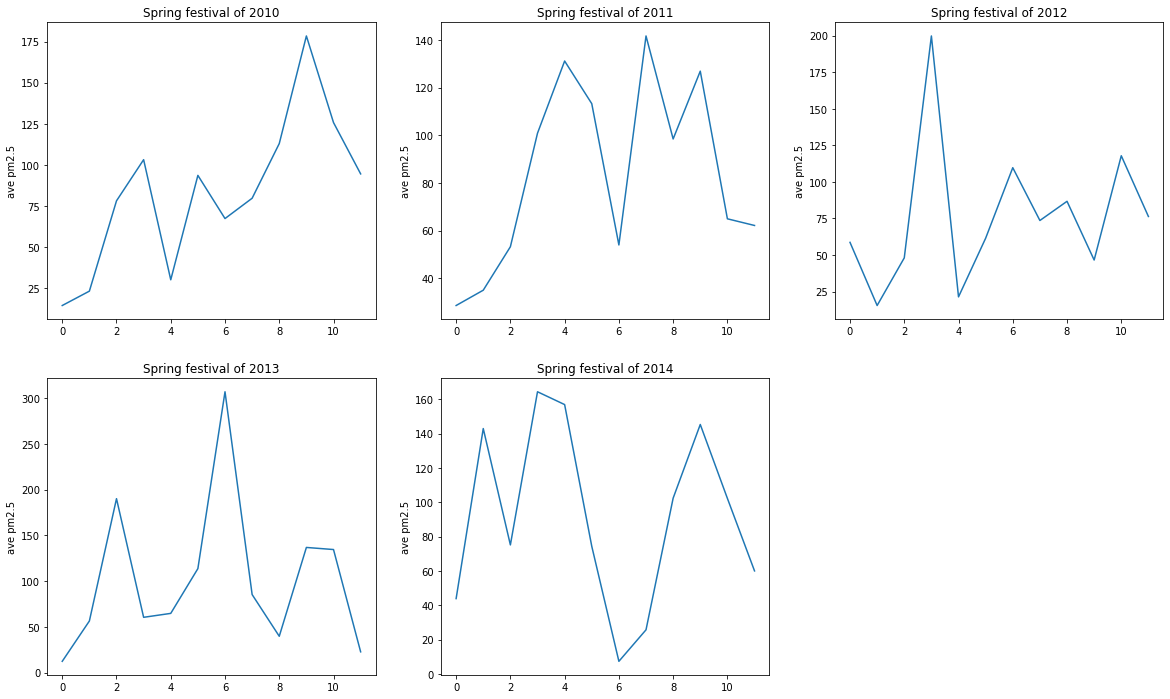

In [67]:
## PM2.5在春节每天的波动值
days_of_sprfest2=[[],[],[],[],[]]
variation_of_days_sprfest2 = pd.DataFrame()

for sprday_2010 in sprfest_2010:
    pm25_day_sprfest_2010=pm25_sprfest_2010[pm25_sprfest_2010.date==sprday_2010]
    mean_spr_2010=np.mean(pm25_day_sprfest_2010['pm2.5'])
    days_of_sprfest2[0].append(mean_spr_2010)

for sprday_2011 in sprfest_2011:
    pm25_day_sprfest_2011=pm25_sprfest_2011[pm25_sprfest_2011.date==sprday_2011]
    mean_spr_2011=np.mean(pm25_day_sprfest_2011['pm2.5'])
    days_of_sprfest2[1].append(mean_spr_2011)

for sprday_2012 in sprfest_2012:
    pm25_day_sprfest_2012=pm25_sprfest_2012[pm25_sprfest_2012.date==sprday_2012]
    mean_spr_2012=np.mean(pm25_day_sprfest_2012['pm2.5'])
    days_of_sprfest2[2].append(mean_spr_2012)

for sprday_2013 in sprfest_2013:
    pm25_day_sprfest_2013=pm25_sprfest_2013[pm25_sprfest_2013.date==sprday_2013]
    mean_spr_2013=np.mean(pm25_day_sprfest_2013['pm2.5'])
    days_of_sprfest2[3].append(mean_spr_2013)

for sprday_2014 in sprfest_2014:
    pm25_day_sprfest_2014=pm25_sprfest_2014[pm25_sprfest_2014.date==sprday_2014]
    mean_spr_2014=np.mean(pm25_day_sprfest_2014['pm2.5'])
    days_of_sprfest2[4].append(mean_spr_2014)

variation_of_days_sprfest2=variation_of_days_sprfest2.append(days_of_sprfest2)

plt.figure(figsize=(20,12))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(Spr,variation_of_days_sprfest2.iloc[i,:])
    plt.title('Spring festival of %d' % Year[i])
    plt.ylabel('ave pm2.5')

In [68]:
variation_of_days_sprfest2

,0,1,2,3,4,5,6,7,8,9,10,11
0,14.333333,23.083333,78.083333,103.150000,30.000000,93.583333,67.291667,79.666667,112.958333,178.500000,125.750000,94.500000
1,28.666667,35.083333,53.291667,100.875000,131.125000,113.250000,54.041667,141.625000,98.458333,126.875000,65.000000,62.208333
2,58.666667,15.458333,48.041667,199.875000,21.375000,61.500000,109.750000,73.625000,86.750000,46.583333,117.916667,76.375000
3,12.416667,56.458333,190.125000,60.500000,64.791667,113.708333,306.916667,85.359375,39.791667,136.833333,134.541667,22.791667
4,43.916667,142.875000,75.166667,164.291667,156.833333,74.375000,7.416667,25.750000,102.375000,145.250000,102.250000,60.041667


## 与原数据相比，平均浓度的数值大小和变化趋势均基本一样，平均浓度基本均出现3个高峰，分别在除夕前后，初三前后和初七前后

## 综上所述，显然k近邻法填补数据更能模拟原数据结构